# Download the dataset

In [1]:
!pip install -q kaggle
!pip install -q kaggle-cli

!pip install copick git+https://github.com/copick/copick-utils.git scikit-image cupy-cuda12x torch torchvision tqdm matplotlib

from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 53.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for lxml
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (lxml)
  Cloning https://github.com/copi

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"griselelianaquispe","key":"e25b634756f74e0780cb4e53f607a06d"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install kaggle

In [5]:
!kaggle competitions download -c czii-cryo-et-object-identification

100% 8.46G/8.46G [05:33<00:00, 21.7MB/s]
100% 8.46G/8.46G [05:33<00:00, 27.2MB/s]


In [6]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [7]:
import zipfile
import os

# Chemin vers votre fichier zip
zip_path = "/content/czii-cryo-et-object-identification.zip"

# Répertoire de destination
extract_path = "/content/data"

# Décompresser le fichier
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Vérifier le contenu du répertoire extrait
print("Contenu du répertoire extrait:")
for root, dirs, files in os.walk(os.path.join(extract_path, "czii-cryo-et-object-identification")):
    for name in files:
        print(os.path.join(root, name))

Contenu du répertoire extrait:


In [8]:
import numpy as np
from glob import glob
import os
import pandas as pd
import zarr

In [9]:
#Optional for experiment
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv3d, nn.ConvTranspose3d)):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


In [10]:
pip install torchviz


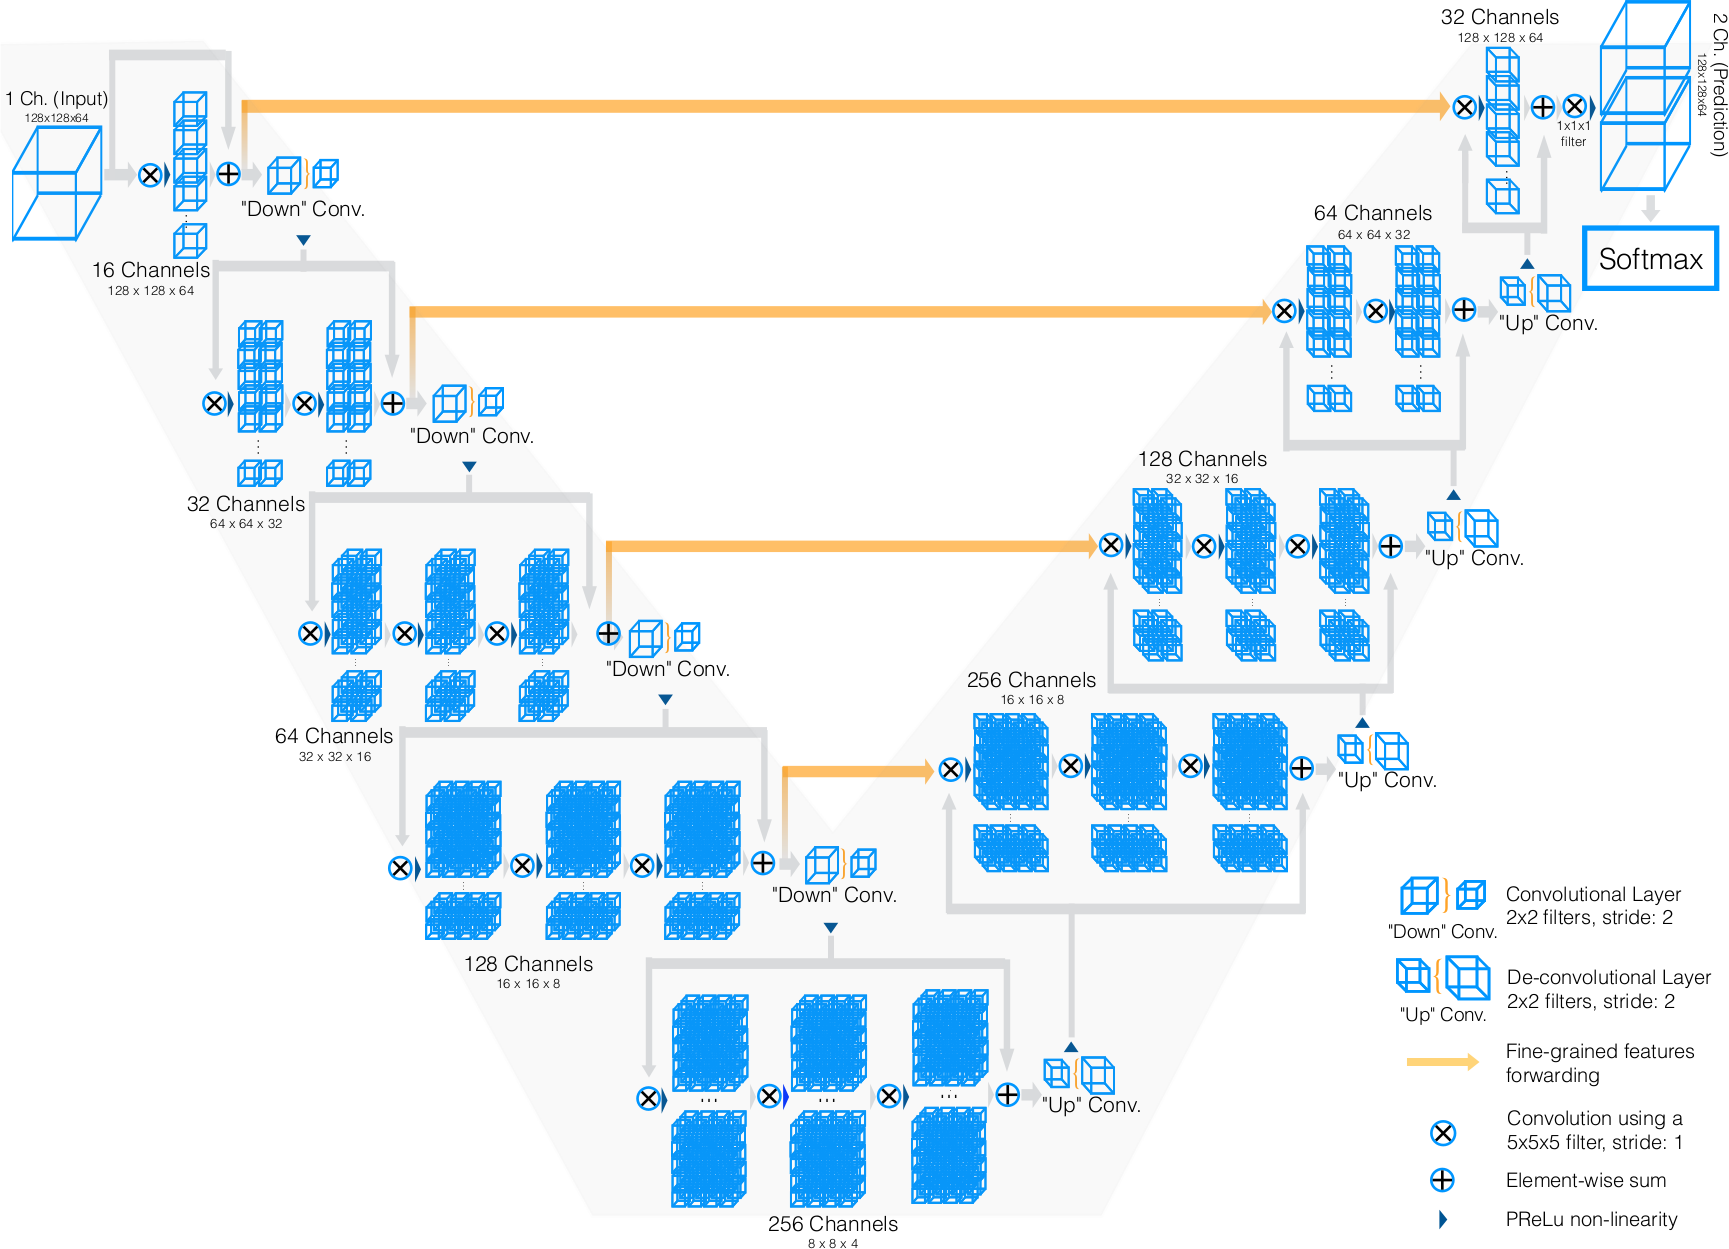

# VNET A

In [ ]:
#Vnet
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    """Convolutional Block with PReLU activation."""
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, padding=2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        self.prelu = nn.PReLU(num_parameters=out_channels)

    def forward(self, x):
        return self.prelu(self.conv(x))

class ResidualBlock(nn.Module):
    """Residual Block with skip connections."""
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.skip_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = self.skip_conv(x) if self.skip_conv else x
        x = self.conv1(x)
        x = self.conv2(x)
        return x + residual

class DownBlock(nn.Module):
    """Down-sampling block with Residual Block."""
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.residual = ResidualBlock(in_channels, out_channels)
        self.down_conv = nn.Conv3d(out_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.residual(x)
        return self.down_conv(x), x  # Return down-sampled output and skip connection

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up_conv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.adjust_channels = nn.Conv3d(out_channels + out_channels * 2, out_channels, kernel_size=1)
        self.residual = ResidualBlock(out_channels, out_channels)

    def forward(self, x, skip):
        #print(f"UpBlock input x shape: {x.shape}, skip shape: {skip.shape}")
        # Up-sample the input
        x = self.up_conv(x)
        #print(f"After up_conv: x shape: {x.shape}")
        # Resize skip connection
        skip = nn.functional.interpolate(skip, size=x.shape[2:], mode='trilinear', align_corners=True)
        #print(f"After interpolate: skip shape: {skip.shape}")
        # Concatenate and adjust channels
        x = torch.cat((x, skip), dim=1)

        #print(f"After concat: x shape: {x.shape}")
        x = self.adjust_channels(x)  # Alinear canales antes del ResidualBlock
        #print(f"After adjust_channels: x shape: {x.shape}")
        x = self.residual(x)
        #print(f"After residual block: x shape: {x.shape}")
        return (x)


class VNet(nn.Module):
    """V-Net Architecture."""
    def __init__(self, in_channels=1, out_channels=1):
        super(VNet, self).__init__()
        # Down-sampling path
        self.in_block = ResidualBlock(in_channels, 16)
        self.down1 = DownBlock(16, 32)
        self.down2 = DownBlock(32, 64)
        self.down3 = DownBlock(64, 128)
        self.down4 = DownBlock(128, 256)

        # Up-sampling path
        self.up1 = UpBlock(256, 128)
        self.up2 = UpBlock(128, 64)
        self.up3 = UpBlock(64, 32)
        self.up4 = UpBlock(32, 16)

        # Output block
        self.out_conv = nn.Conv3d(16, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        # Down-sampling
        x1 = self.in_block(x)
        #print(f"Shape after in_block: {x1.shape}")

        x2, skip1 = self.down1(x1)
        #print(f"Shape after down1: {x2.shape}, skip1: {skip1.shape}")

        x3, skip2 = self.down2(x2)
        #print(f"Shape after down2: {x3.shape}, skip2: {skip2.shape}")

        x4, skip3 = self.down3(x3)
        #print(f"Shape after down3: {x4.shape}, skip3: {skip3.shape}")

        x5, skip4 = self.down4(x4)
        #print(f"Shape after down4: {x5.shape}, skip4: {skip4.shape}")

        # Up-sampling
        x = self.up1(x5, skip4)
        #print(f"Shape after up1: {x.shape}, skip4: {skip4.shape}")

        x = self.up2(x, skip3)
        #print(f"Shape after up2: {x.shape}, skip3: {skip3.shape}")
        x = self.up3(x, skip2)
        #print(f"Shape after up3: {x.shape}, skip2: {skip2.shape}")
        x = self.up4(x, skip1)
        #print(f"Shape after up4: {x.shape}, skip1: {skip1.shape}")

        # Output
        x = self.out_conv(x)
        #print(f"Shape after out_conv: {x.shape}")
        return self.sigmoid(x)


# V-NET B

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BatchNorm3d

def passthrough(x, **kwargs):
    return x

def ELUCons(elu, nchan):
    if elu:
        return nn.ELU(inplace=True)
    else:
        return nn.PReLU(nchan)

# normalization between sub-volumes is necessary
# for good performance
'''
class ContBatchNorm3d(nn.modules.batchnorm._BatchNorm):
    def forward(self, input):
        # Ensure input is 5D (batch_size, channels, depth, height, width)
        if input.dim() != 5:
            raise ValueError(f"Expected 5D input (got {input.dim()}D input)")
        # Use the default behavior of BatchNorm3d
        return super(ContBatchNorm3d, self).forward(input)
'''
class ContBatchNorm3d(nn.BatchNorm3d):
    # No need to override or add behavior here
    pass



class LUConv(nn.Module):
    def __init__(self, nchan, elu):
        super(LUConv, self).__init__()
        self.relu1 = ELUCons(elu, nchan)
        self.conv1 = nn.Conv3d(nchan, nchan, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(nchan)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        return out


def _make_nConv(nchan, depth, elu):
    layers = []
    for _ in range(depth):
        layers.append(LUConv(nchan, elu))
    return nn.Sequential(*layers)


class InputTransition(nn.Module):
    def __init__(self, outChans, elu):
        super(InputTransition, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(16)
        self.relu1 = ELUCons(elu, 16)

    def forward(self, x):
        # do we want a PRELU here as well?
        out = self.bn1(self.conv1(x))
        # split input in to 16 channels
        x16 = x.repeat(1, 16, 1, 1, 1)  # Duplicate channels
        out = self.relu1(torch.add(out, x16))
        return out


class DownTransition(nn.Module):
    def __init__(self, inChans, nConvs, elu, dropout=False):
        super(DownTransition, self).__init__()
        outChans = 2*inChans
        self.down_conv = nn.Conv3d(inChans, outChans, kernel_size=2, stride=2)
        self.bn1 = ContBatchNorm3d(outChans)
        self.do1 = passthrough
        self.relu1 = ELUCons(elu, outChans)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x):
        down = self.relu1(self.bn1(self.down_conv(x)))
        out = self.do1(down)
        out = self.ops(out)
        out = self.relu2(torch.add(out, down))
        return out


class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, nConvs, elu, dropout=False):
        super(UpTransition, self).__init__()
        self.up_conv = nn.ConvTranspose3d(inChans, outChans // 2, kernel_size=2, stride=2)
        self.bn1 = ContBatchNorm3d(outChans // 2)
        self.do1 = passthrough
        self.do2 = nn.Dropout3d()
        self.relu1 = ELUCons(elu, outChans // 2)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x, skipx):
        out = self.do1(x)
        skipxdo = self.do2(skipx)
        out = self.relu1(self.bn1(self.up_conv(out)))
        xcat = torch.cat((out, skipxdo), 1)
        out = self.ops(xcat)
        out = self.relu2(torch.add(out, xcat))
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, elu, nll):
        super(OutputTransition, self).__init__()
        self.conv1 = nn.Conv3d(inChans, 2, kernel_size=5, padding=2)
        self.bn1 = ContBatchNorm3d(2)
        self.conv2 = nn.Conv3d(2, 2, kernel_size=1)
        self.relu1 = ELUCons(elu, 2)
        if nll:
            self.softmax = F.log_softmax
        else:
            self.softmax = F.softmax

    def forward(self, x):
        # Convolve down to 2 channels
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.conv2(out)

        # Apply softmax or log_softmax across the channel dimension
        out = self.softmax(out, dim=1)  # Keep spatial dimensions intact
        return out


class VNet(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, elu=True, nll=False):
        super(VNet, self).__init__()
        self.in_tr = InputTransition(16, elu)
        self.down_tr32 = DownTransition(16, 1, elu)
        self.down_tr64 = DownTransition(32, 2, elu)
        self.down_tr128 = DownTransition(64, 3, elu, dropout=True)
        self.down_tr256 = DownTransition(128, 2, elu, dropout=True)
        self.up_tr256 = UpTransition(256, 256, 2, elu, dropout=True)
        self.up_tr128 = UpTransition(256, 128, 2, elu, dropout=True)
        self.up_tr64 = UpTransition(128, 64, 1, elu)
        self.up_tr32 = UpTransition(64, 32, 1, elu)
        self.out_tr = OutputTransition(32, elu, nll)

    # The network topology as described in the diagram
    # in the VNet paper
    # def __init__(self):
    #     super(VNet, self).__init__()
    #     self.in_tr =  InputTransition(16)
    #     # the number of convolutions in each layer corresponds
    #     # to what is in the actual prototxt, not the intent
    #     self.down_tr32 = DownTransition(16, 2)
    #     self.down_tr64 = DownTransition(32, 3)
    #     self.down_tr128 = DownTransition(64, 3)
    #     self.down_tr256 = DownTransition(128, 3)
    #     self.up_tr256 = UpTransition(256, 3)
    #     self.up_tr128 = UpTransition(128, 3)
    #     self.up_tr64 = UpTransition(64, 2)
    #     self.up_tr32 = UpTransition(32, 1)
    #     self.out_tr = OutputTransition(16)
    def forward(self, x):
        out16 = self.in_tr(x)
        out32 = self.down_tr32(out16)
        out64 = self.down_tr64(out32)
        out128 = self.down_tr128(out64)
        out256 = self.down_tr256(out128)
        out = self.up_tr256(out256, out128)
        out = self.up_tr128(out, out64)
        out = self.up_tr64(out, out32)
        out = self.up_tr32(out, out16)
        out = self.out_tr(out)
        return out

In [12]:
import torch
import torch.nn as nn

#Loss Function
class BinaryDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): Predicted logits of shape (batch_size, 1, depth, height, width).
            targets (torch.Tensor): Ground truth labels of shape (batch_size, depth, height, width).
        """
        # Apply sigmoid to convert logits to probabilities
        inputs = torch.sigmoid(inputs)

        # Squeeze channel dimension if it exists
        if inputs.shape[1] == 1:
            inputs = inputs.squeeze(1)  # Remove channel dimension

        # Check shapes
        assert inputs.shape == targets.shape, f"Shape mismatch: {inputs.shape} != {targets.shape}"

        # Flatten tensors to calculate intersection and union
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        # Compute Dice coefficient
        intersection = (inputs_flat * targets_flat).sum()
        union = inputs_flat.sum() + targets_flat.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)

        return 1 - dice

In [145]:
# Initialize model and loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VNet(elu=True, nll=False).to(device)
#criterion = BinaryDiceLoss()  # Use your BinaryDiceLoss
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)

In [146]:
import numpy as np
import matplotlib.pyplot as plt

num_epochs = 50

train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for volume, labels in train_dataloader:
        volume, labels = volume.to(device), labels.to(device)
        labels = labels.to(device).float()  # Convert labels to float

        outputs = model(volume)[:, 1, :, :, :]  # foreground logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Average train loss for this epoch
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for volume, labels in val_dataloader:
            volume, labels = volume.to(device), labels.to(device)
            labels = labels.to(device).float()  # Convert labels to float
            outputs = model(volume)[:, 1, :, :, :]
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch [1/50] - Train Loss: 1.0138, Val Loss: 1.0167
Epoch [2/50] - Train Loss: 0.9624, Val Loss: 1.1268
Epoch [3/50] - Train Loss: 0.9331, Val Loss: 0.9774
Epoch [4/50] - Train Loss: 0.9265, Val Loss: 0.9400
Epoch [5/50] - Train Loss: 0.9095, Val Loss: 1.0199
Epoch [6/50] - Train Loss: 0.9296, Val Loss: 0.9493
Epoch [7/50] - Train Loss: 0.9109, Val Loss: 1.0258
Epoch [8/50] - Train Loss: 0.8994, Val Loss: 0.9483
Epoch [9/50] - Train Loss: 0.8981, Val Loss: 0.9526
Epoch [10/50] - Train Loss: 0.9282, Val Loss: 0.9534
Epoch [11/50] - Train Loss: 0.8951, Val Loss: 0.9418
Epoch [12/50] - Train Loss: 0.8987, Val Loss: 0.9763
Epoch [13/50] - Train Loss: 0.8852, Val Loss: 0.9372
Epoch [14/50] - Train Loss: 0.8900, Val Loss: 0.9397
Epoch [15/50] - Train Loss: 0.9141, Val Loss: 1.0615
Epoch [16/50] - Train Loss: 0.8910, Val Loss: 0.9443
Epoch [17/50] - Train Loss: 0.8930, Val Loss: 0.9448
Epoch [18/50] - Train Loss: 0.8803, Val Loss: 0.9464
Epoch [19/50] - Train Loss: 0.8804, Val Loss: 0.9470
Ep

In [142]:
# Initialize lists for true and predicted labels
all_labels = []
all_preds = []
all_labels2 = []
all_preds2 = []

with torch.no_grad():
    for volume, labels in val_dataloader:
        # Move data to the same device as the model
        volume = volume.to("cuda" if torch.cuda.is_available() else "cpu")
        labels = labels.to("cuda" if torch.cuda.is_available() else "cpu")

        # Forward pass
        outputs = model(volume)

        # Get the predicted class (assuming multi-class classification)
        preds = torch.argmax(outputs, dim=1)

        # Convert to numpy and extend the lists
        all_labels.extend(labels.cpu().numpy().flatten().tolist())
        all_preds.extend(preds.cpu().numpy().flatten().tolist())
        all_labels2.append(labels)
        all_preds2.append(preds)

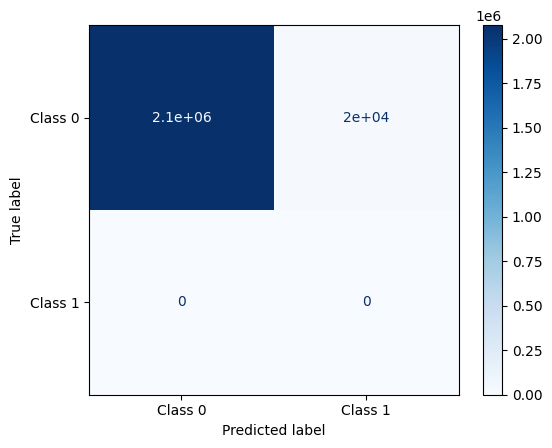

In [143]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(all_preds, all_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")

In [144]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
print(report)


Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00   2076837
     Class 1       0.00      0.00      0.00     20315

    accuracy                           0.99   2097152
   macro avg       0.50      0.50      0.50   2097152
weighted avg       0.98      0.99      0.99   2097152



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


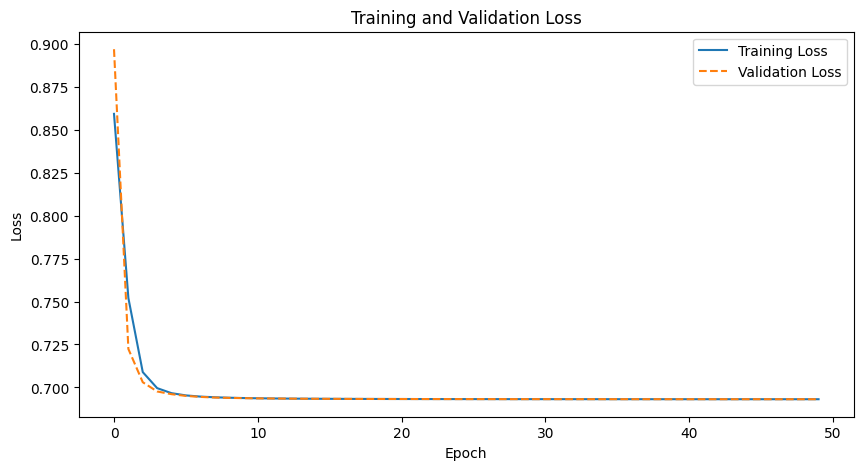

In [140]:
# Plot the Training and Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Sample 0, Slice 10 contains particles.


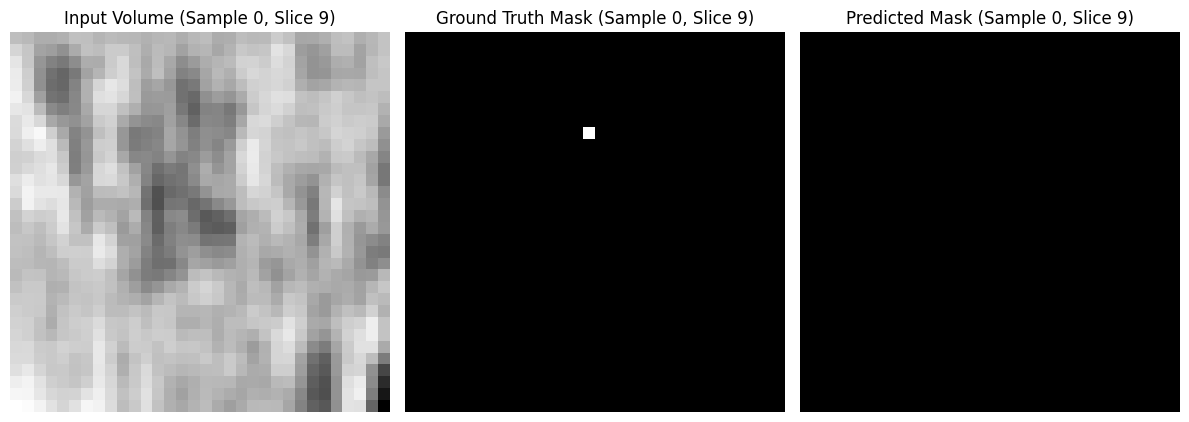

Sample 0, Slice 11 contains particles.


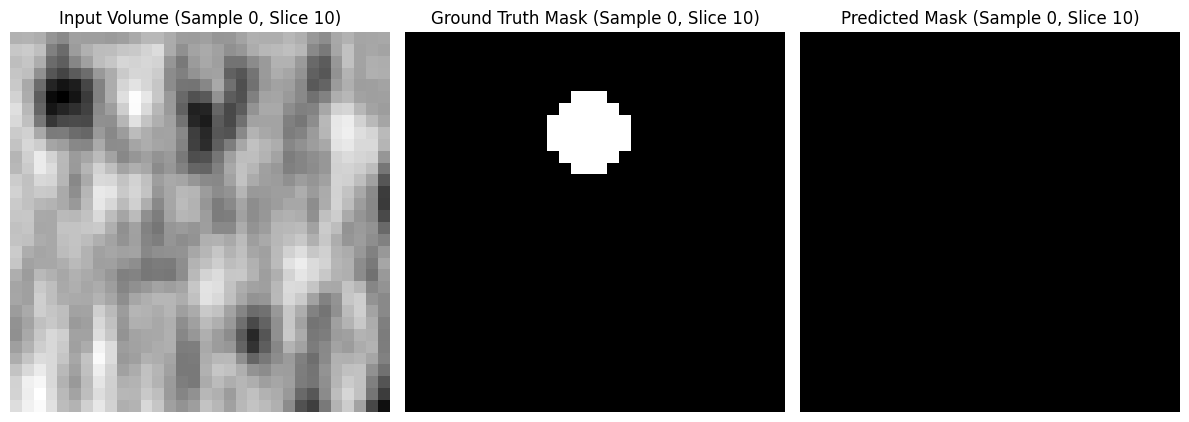

Sample 0, Slice 12 contains particles.


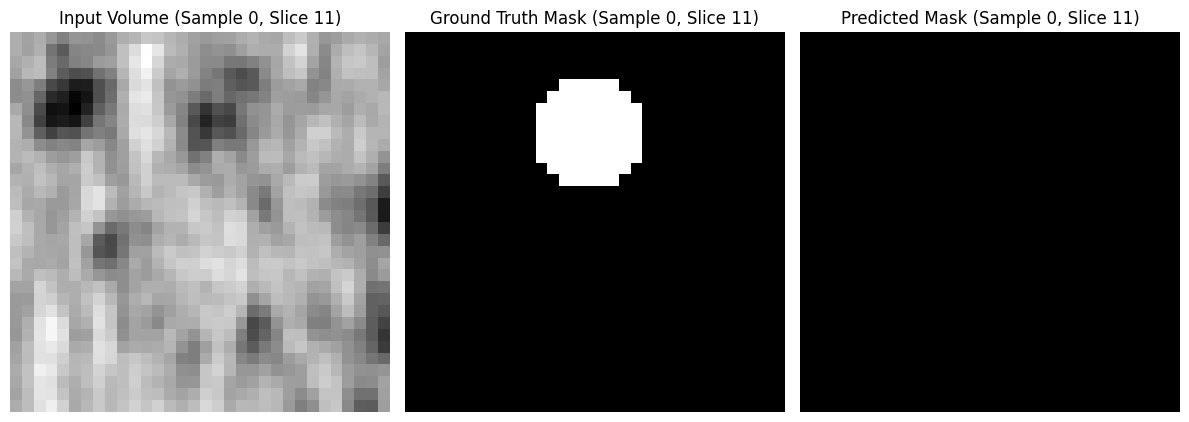

Sample 0, Slice 13 contains particles.


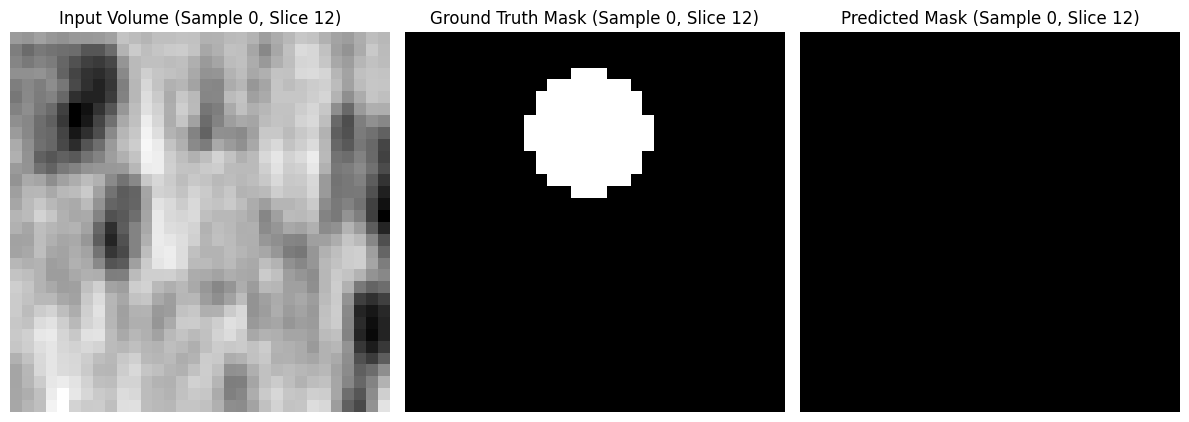

Sample 0, Slice 14 contains particles.


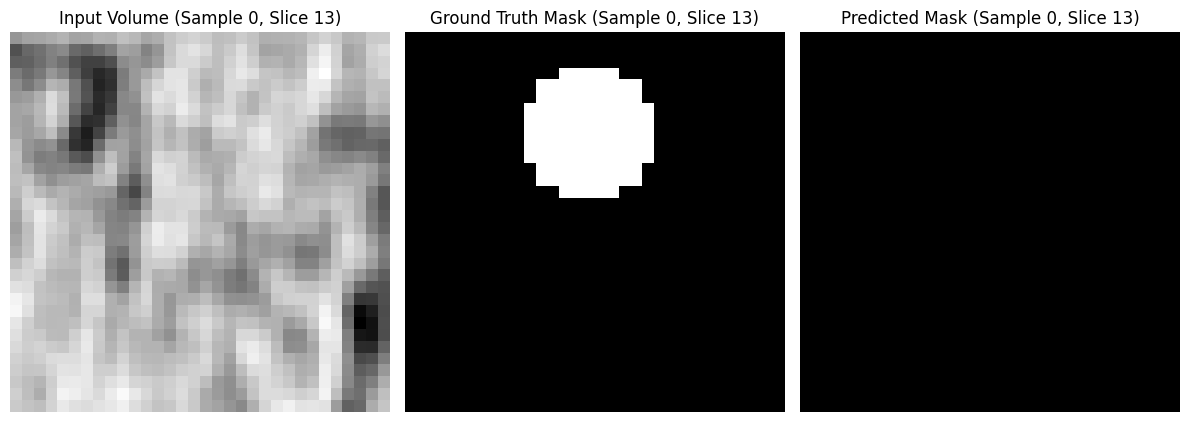

Sample 0, Slice 15 contains particles.


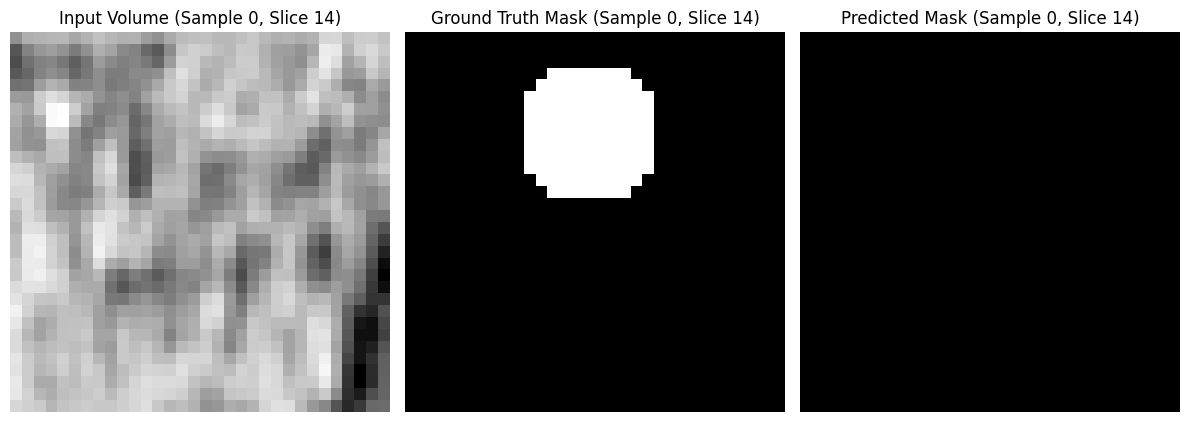

Sample 0, Slice 16 contains particles.


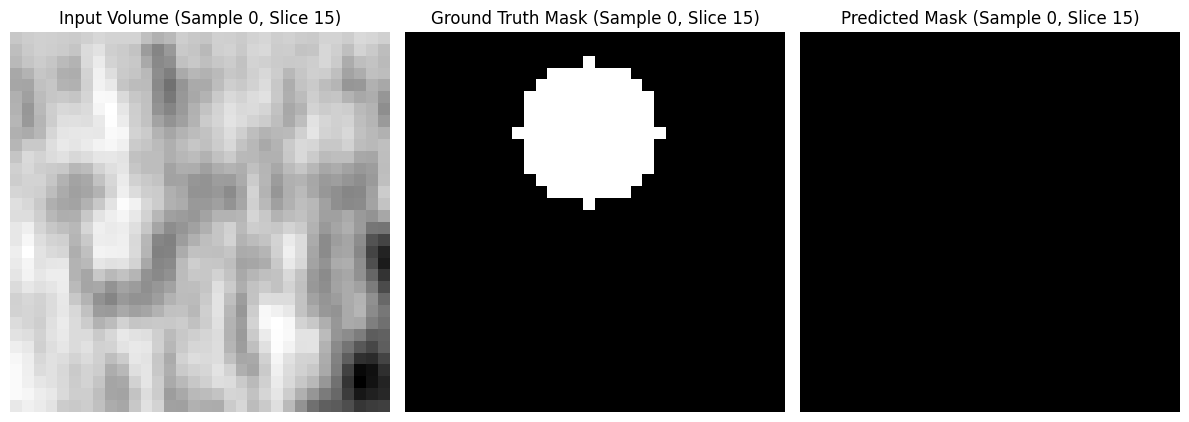

Sample 0, Slice 17 contains particles.


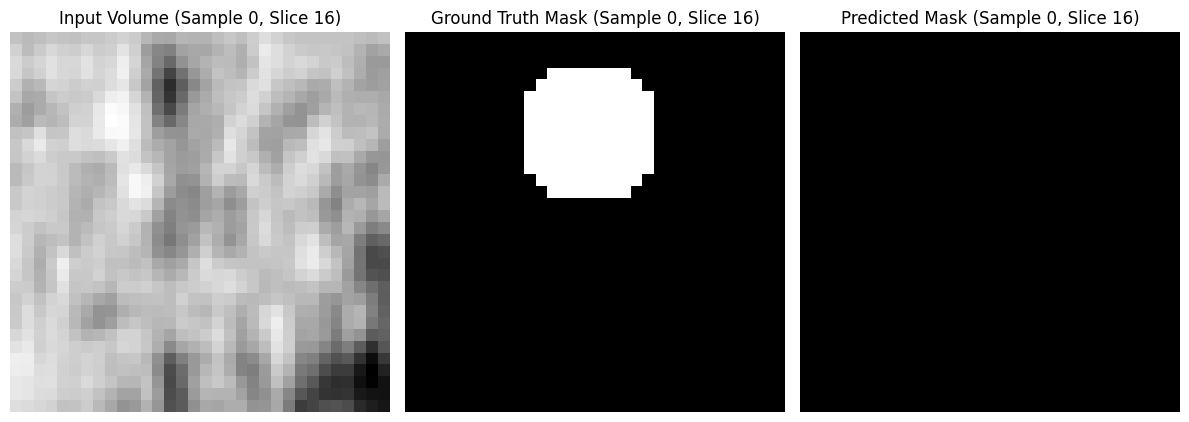

Sample 0, Slice 18 contains particles.


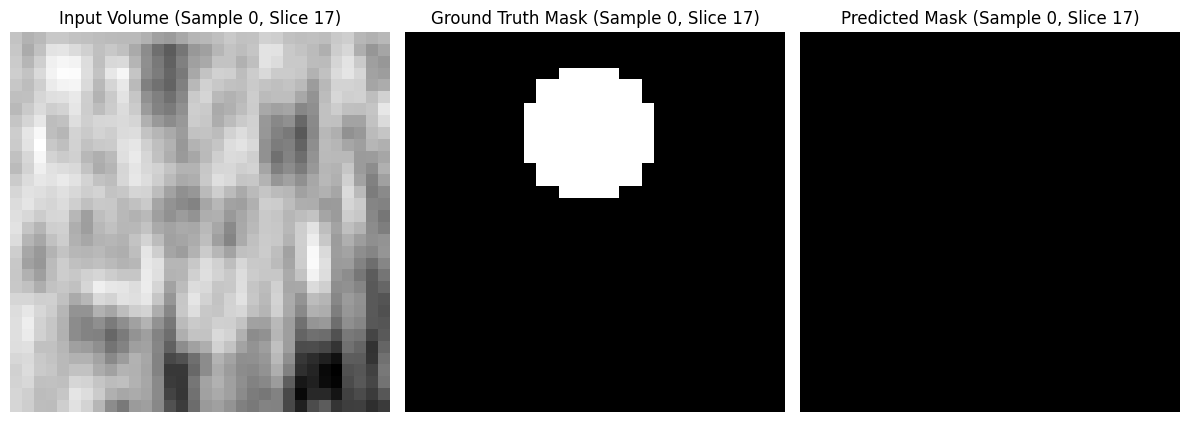

Sample 0, Slice 19 contains particles.


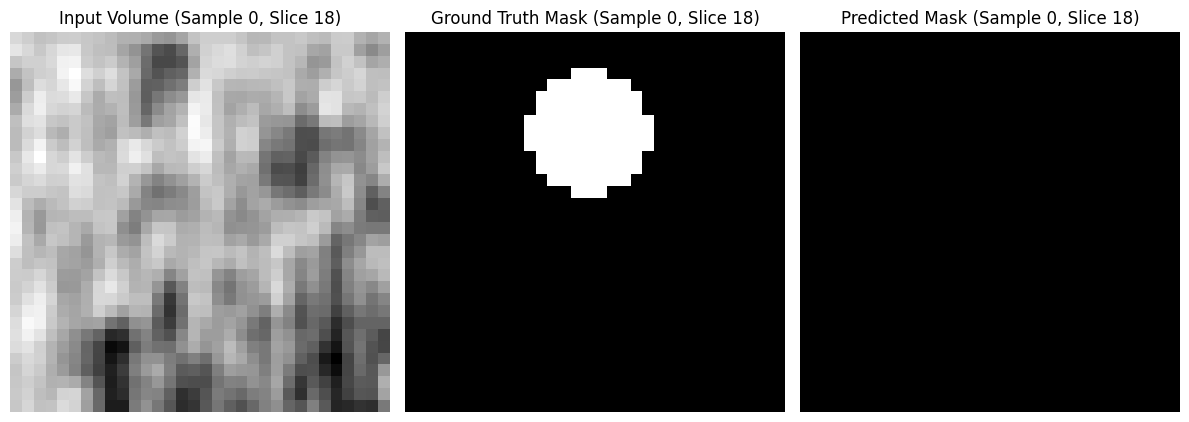

Sample 0, Slice 20 contains particles.


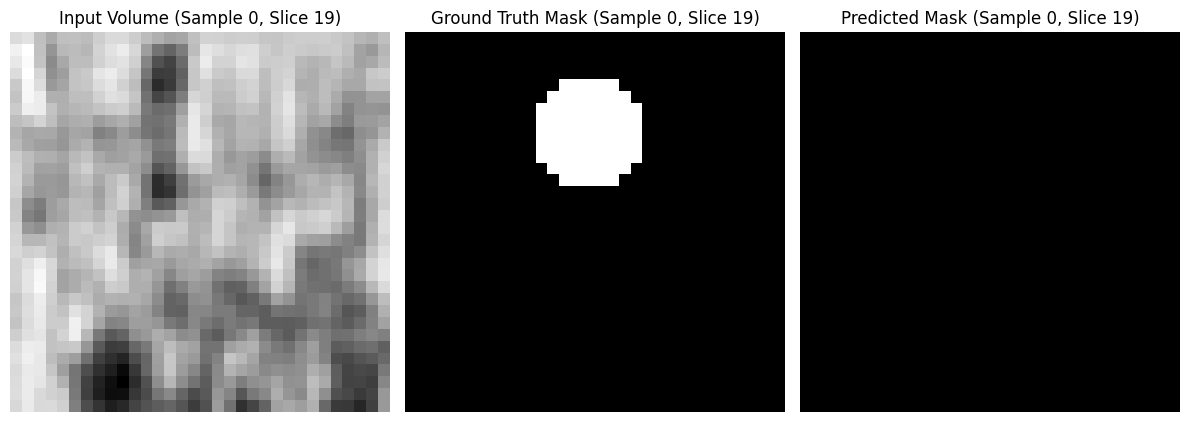

Sample 0, Slice 21 contains particles.


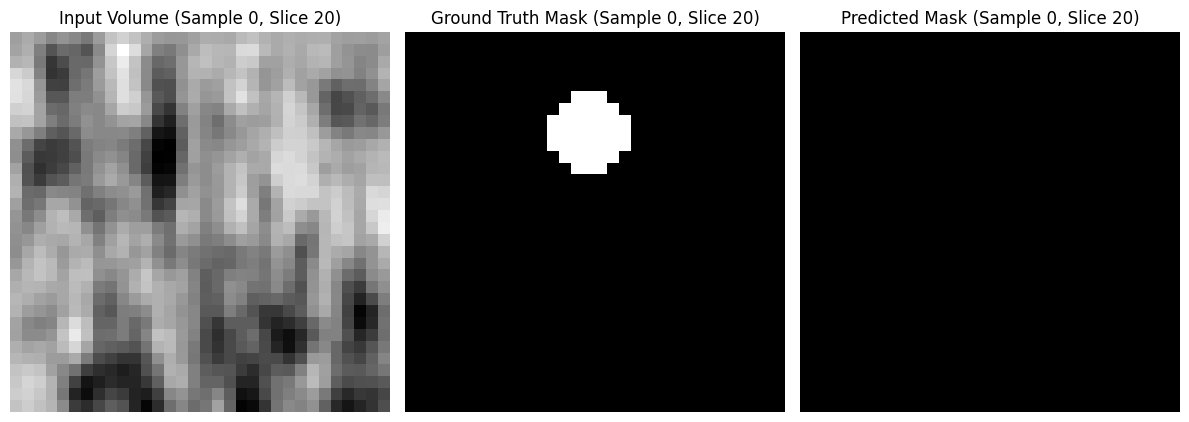

Sample 0, Slice 22 contains particles.


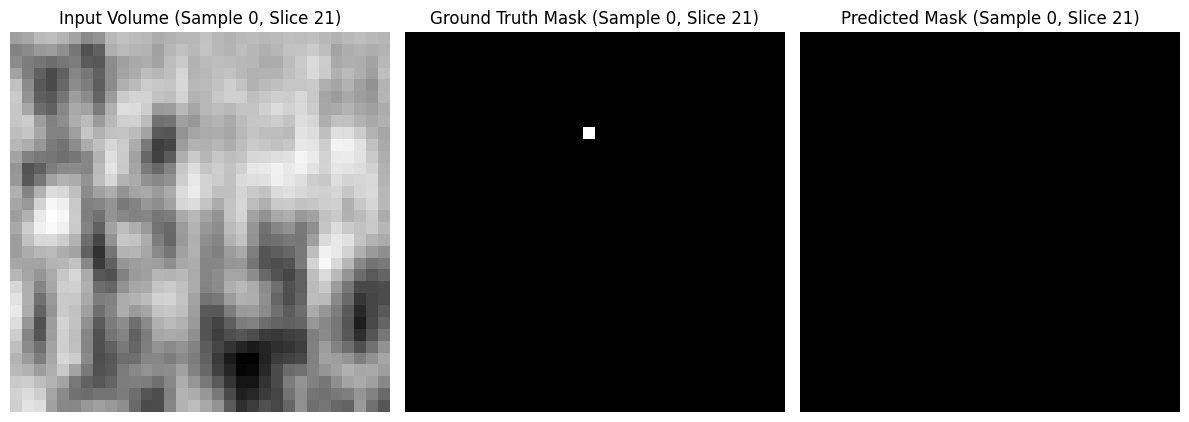

Sample 1, Slice 31 contains particles.


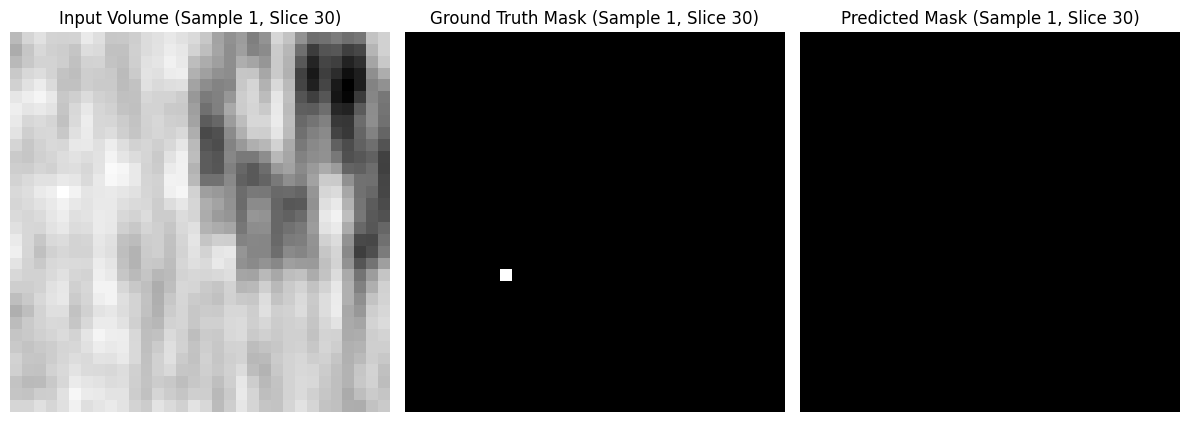

Sample 1, Slice 32 contains particles.


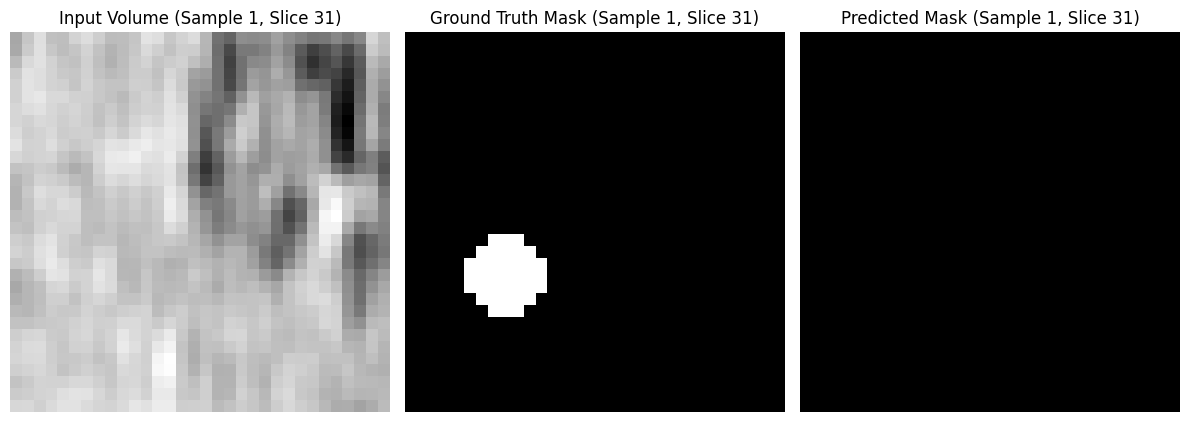

Sample 2, Slice 15 contains particles.


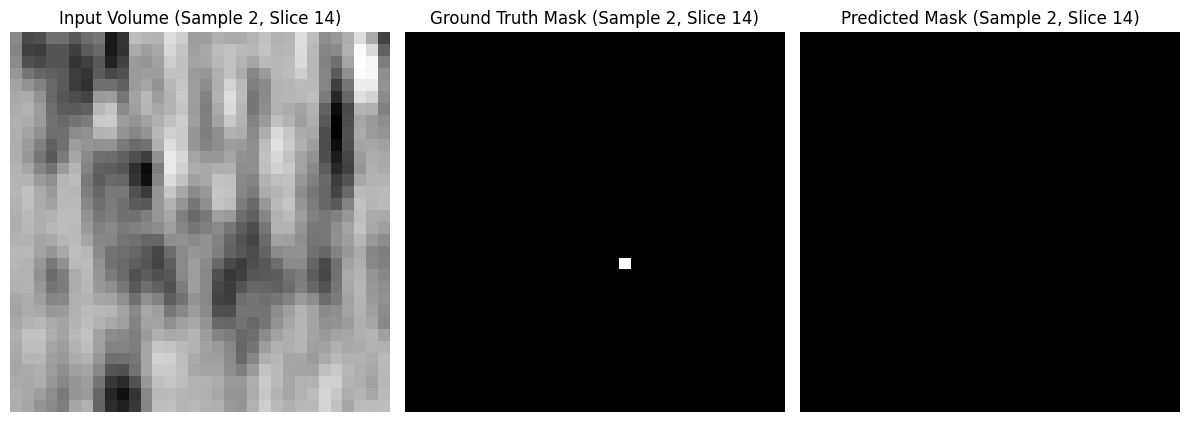

Sample 2, Slice 16 contains particles.


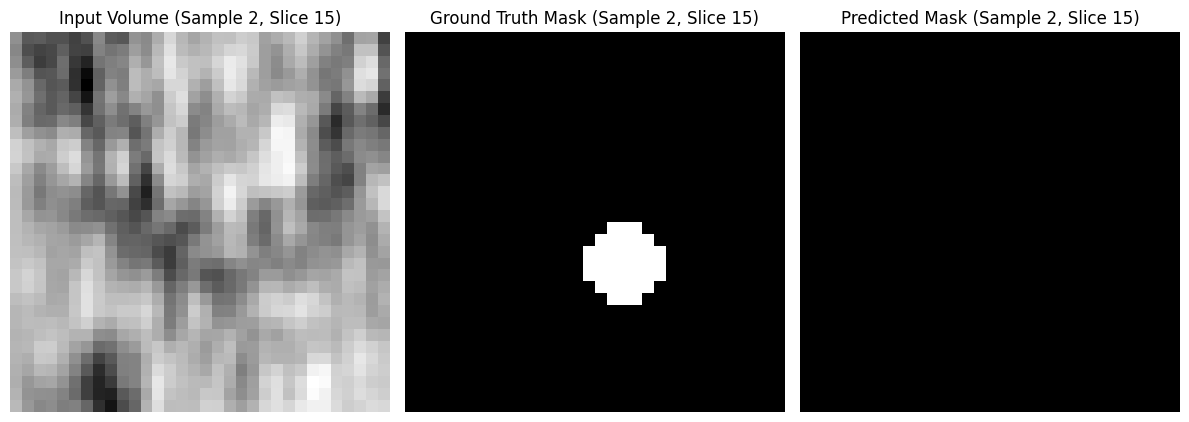

Sample 2, Slice 17 contains particles.


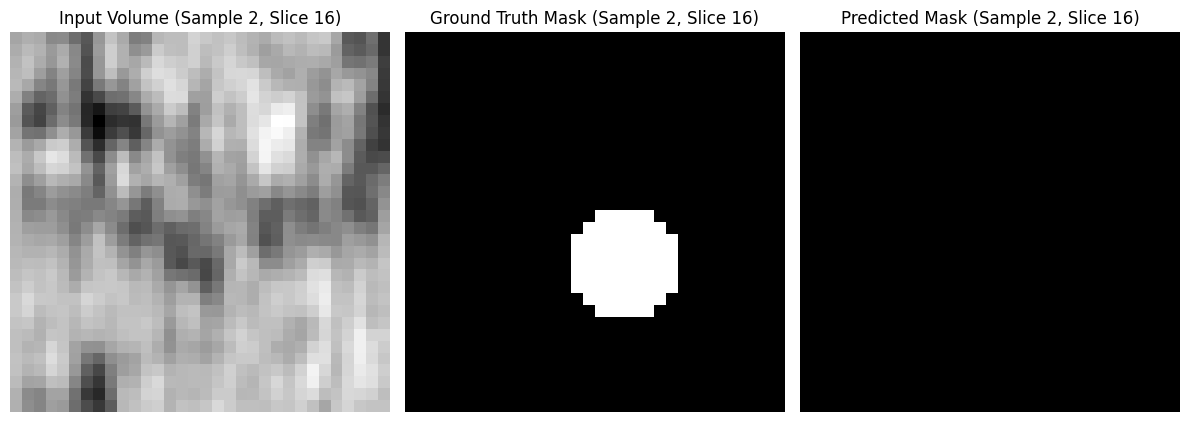

Sample 2, Slice 18 contains particles.


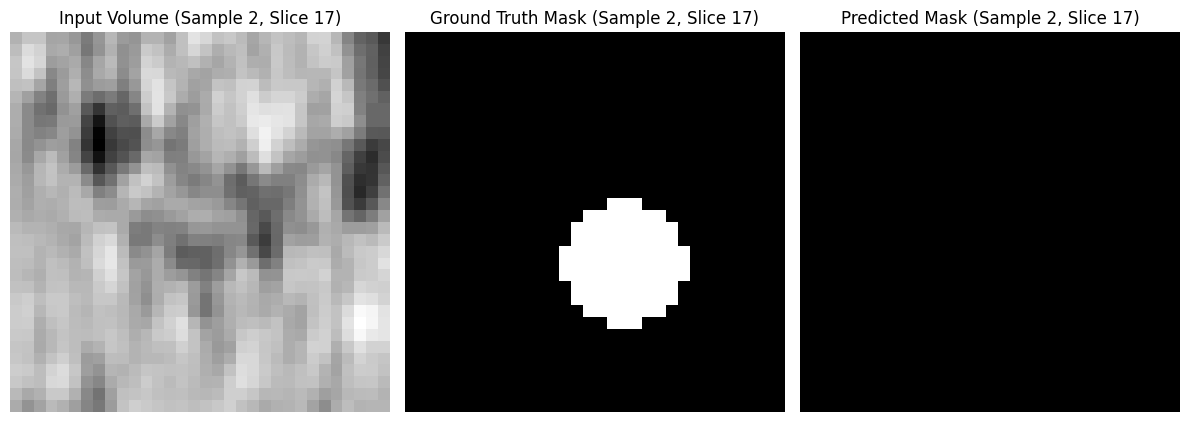

Sample 2, Slice 19 contains particles.


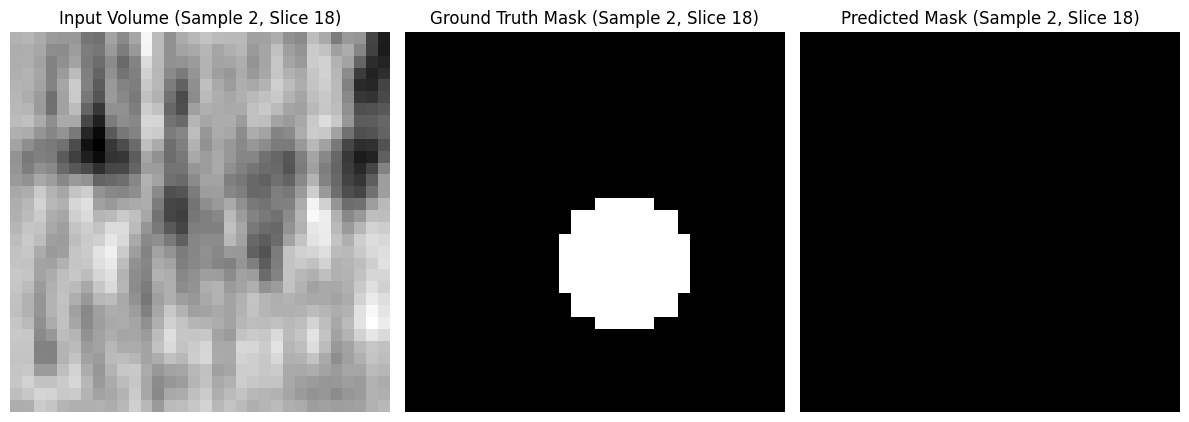

Sample 2, Slice 20 contains particles.


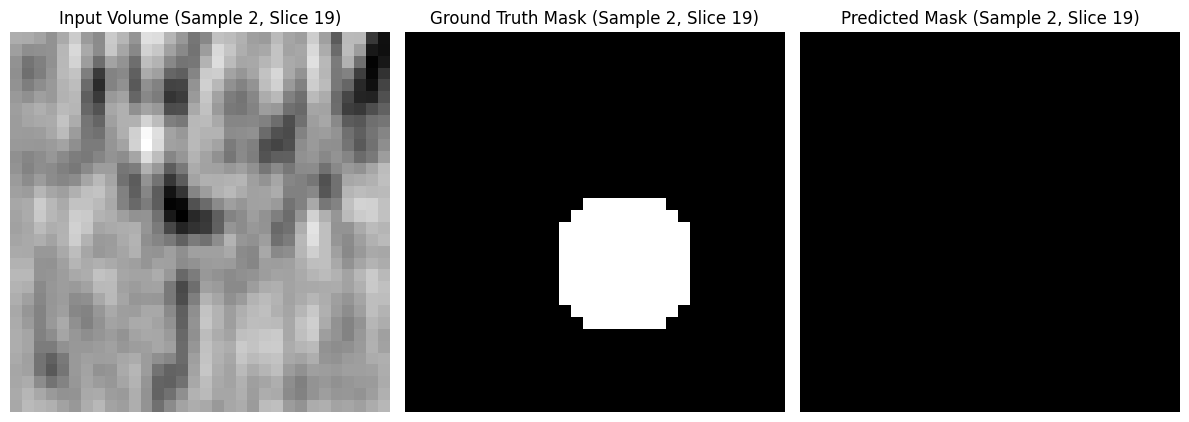

Sample 2, Slice 21 contains particles.


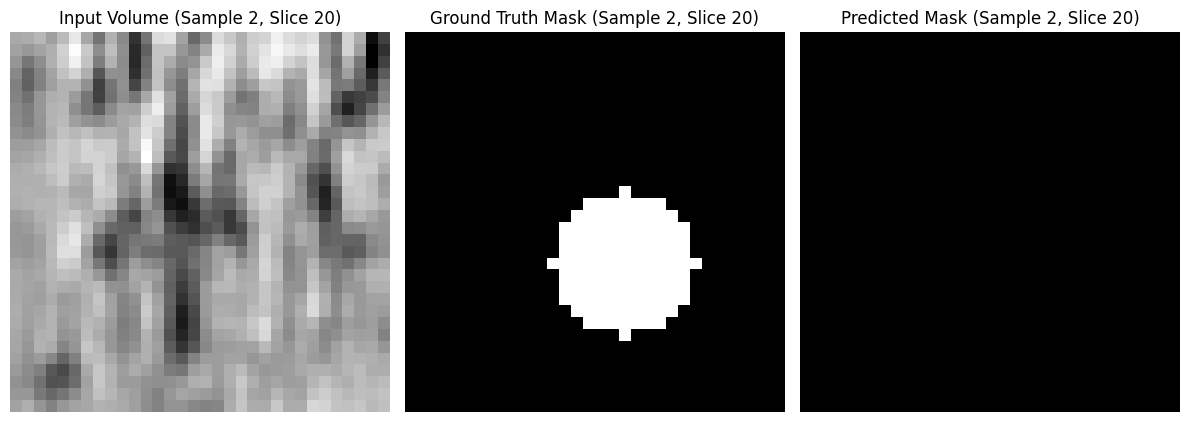

Sample 2, Slice 22 contains particles.


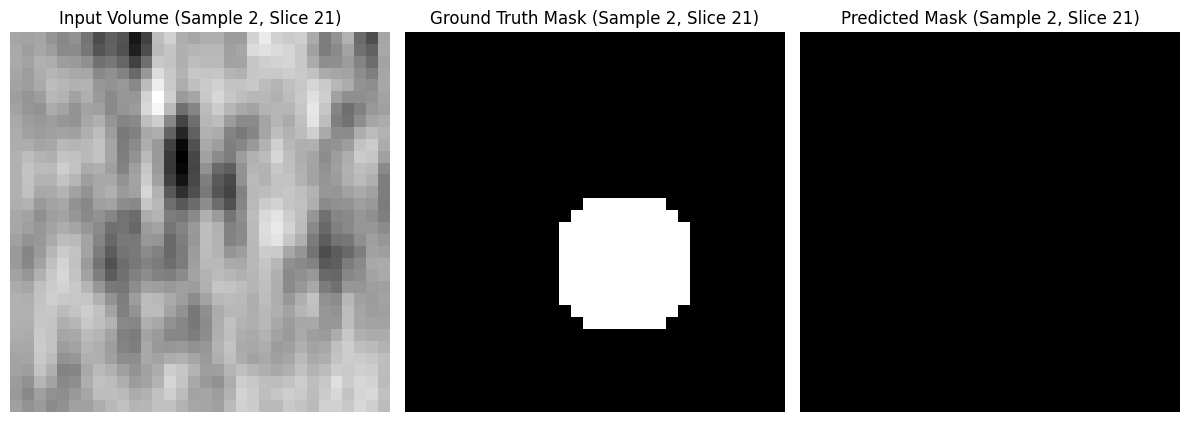

Sample 2, Slice 23 contains particles.


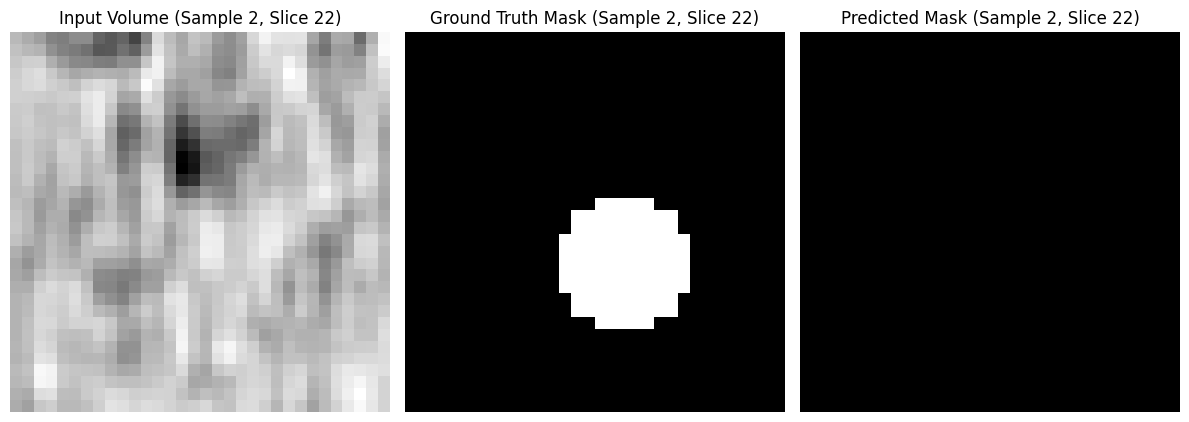

Sample 2, Slice 24 contains particles.


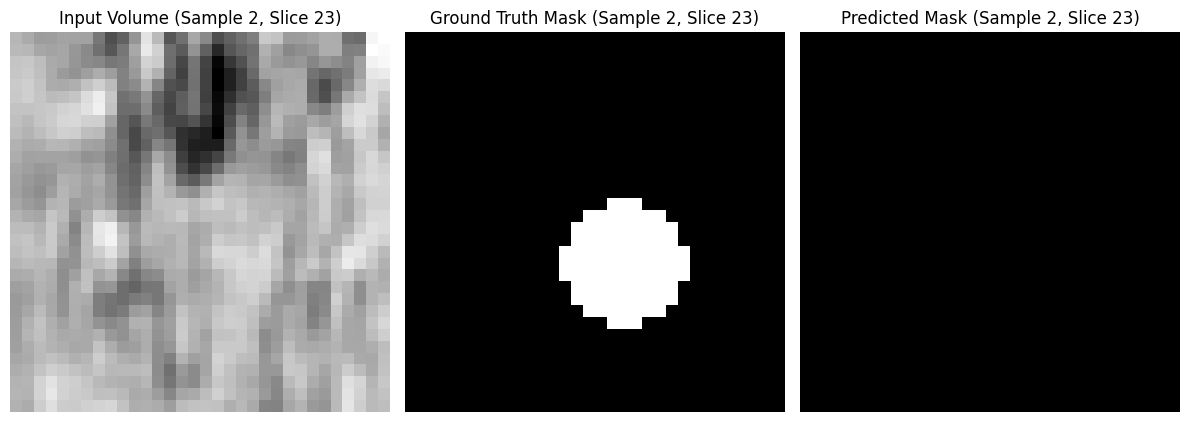

Sample 2, Slice 25 contains particles.


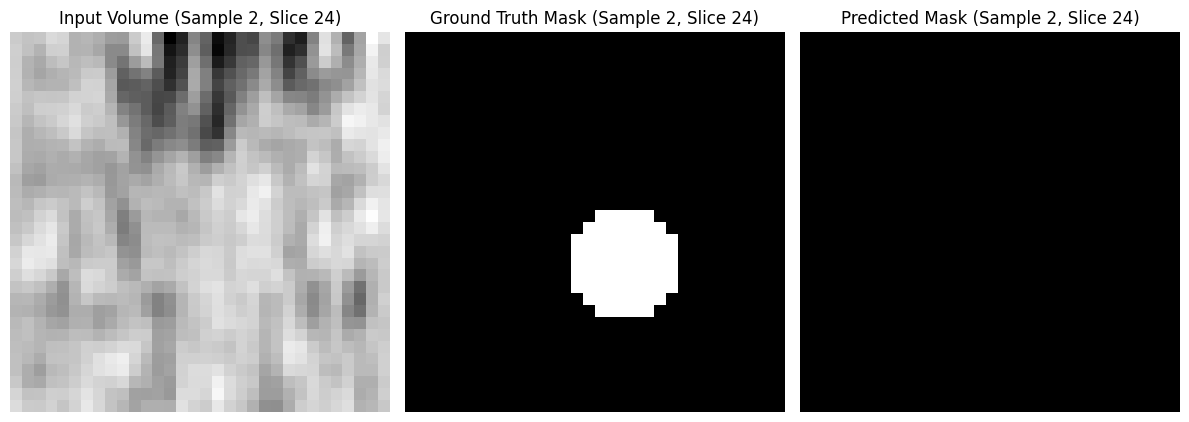

Sample 2, Slice 26 contains particles.


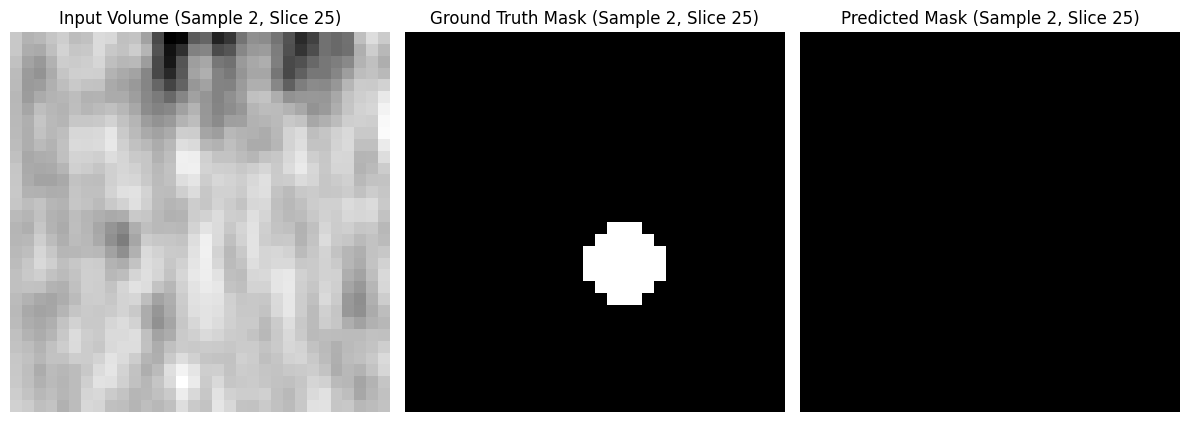

Sample 2, Slice 27 contains particles.


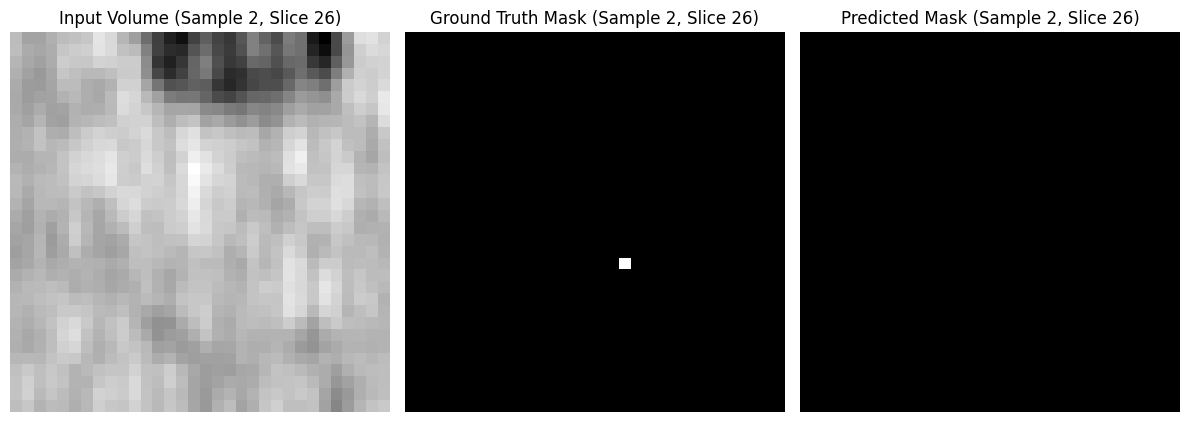

Sample 3, Slice 5 contains particles.


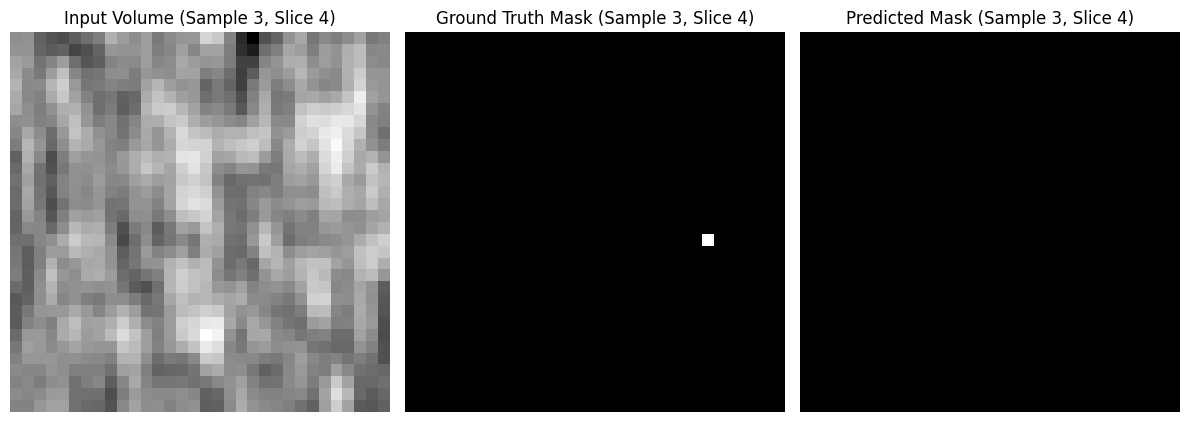

Sample 3, Slice 6 contains particles.


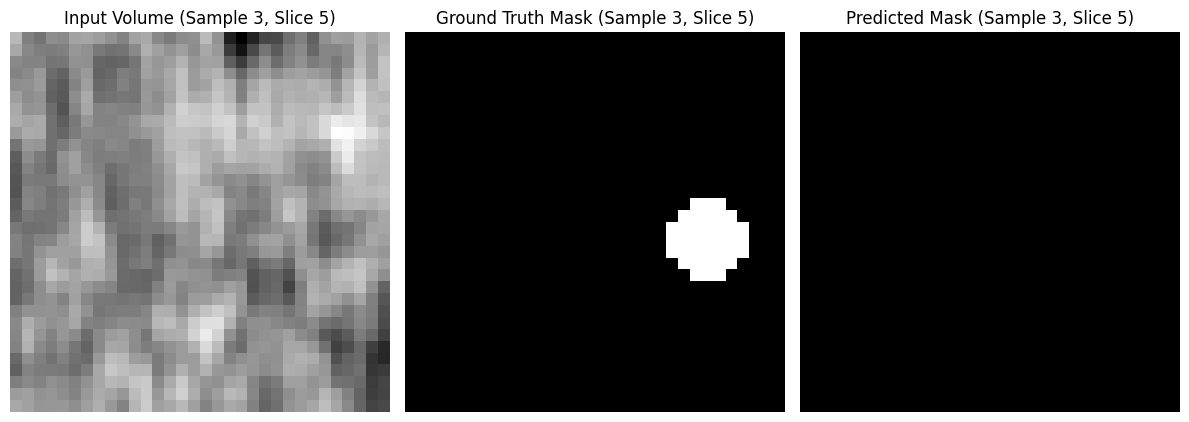

Sample 3, Slice 7 contains particles.


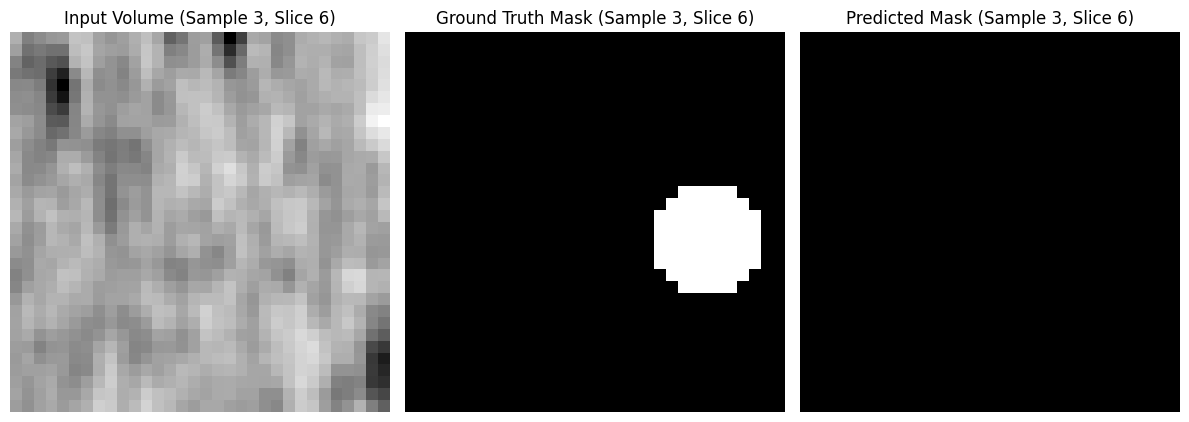

Sample 3, Slice 8 contains particles.


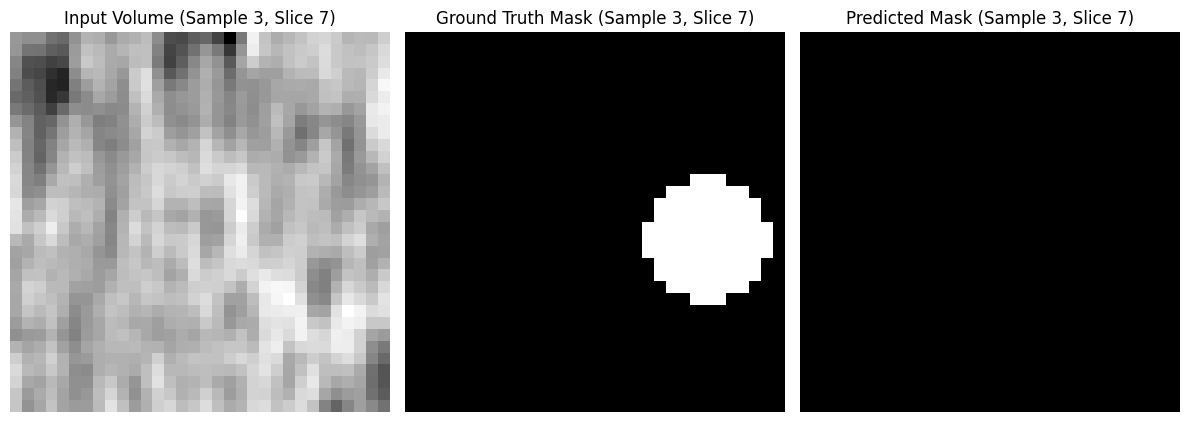

Sample 3, Slice 9 contains particles.


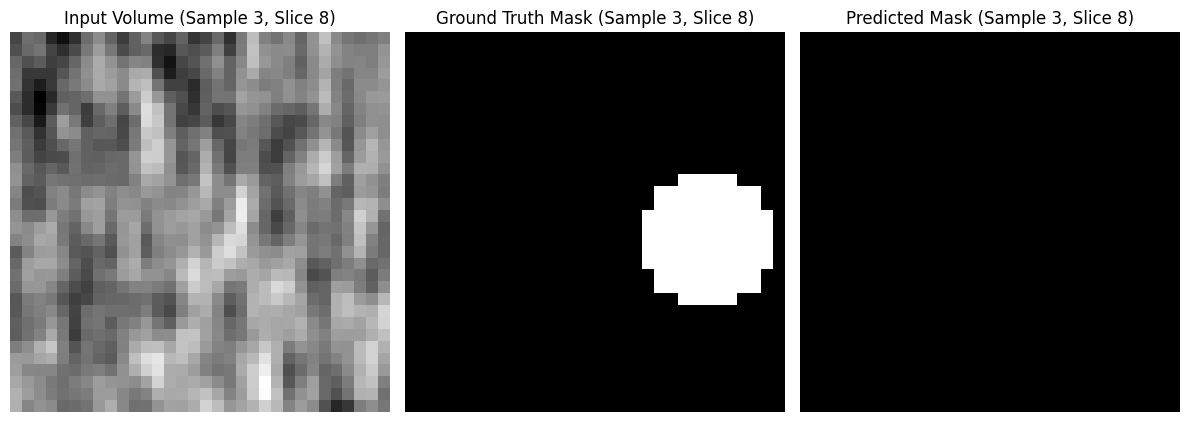

Sample 3, Slice 10 contains particles.


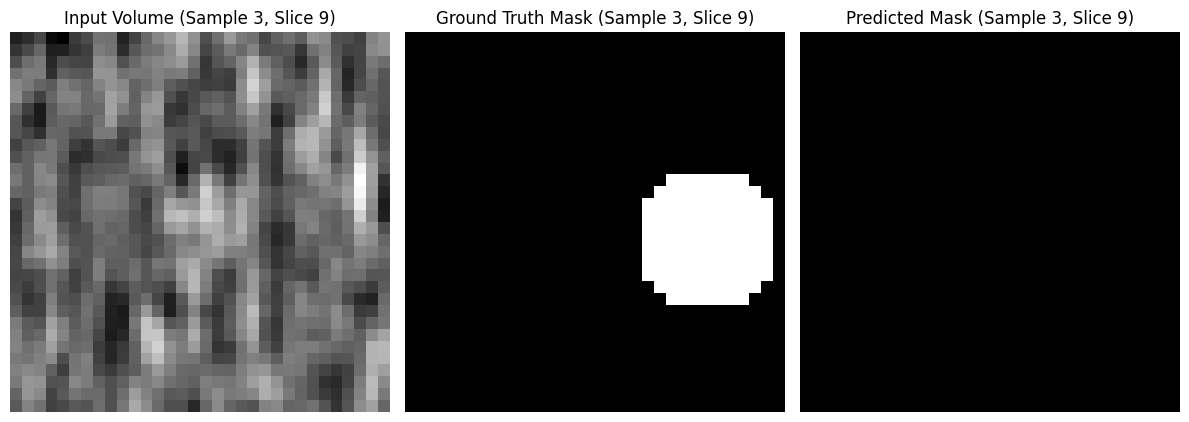

Sample 3, Slice 11 contains particles.


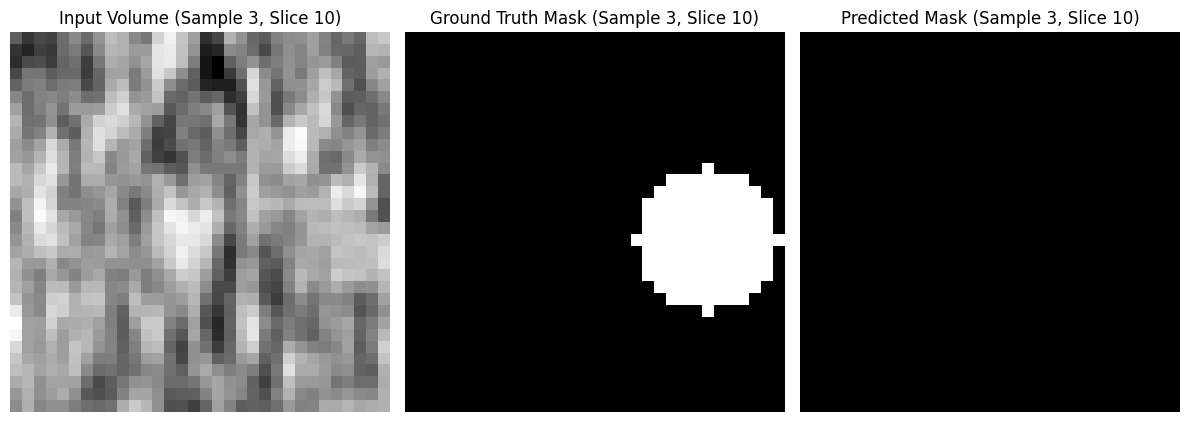

Sample 3, Slice 12 contains particles.


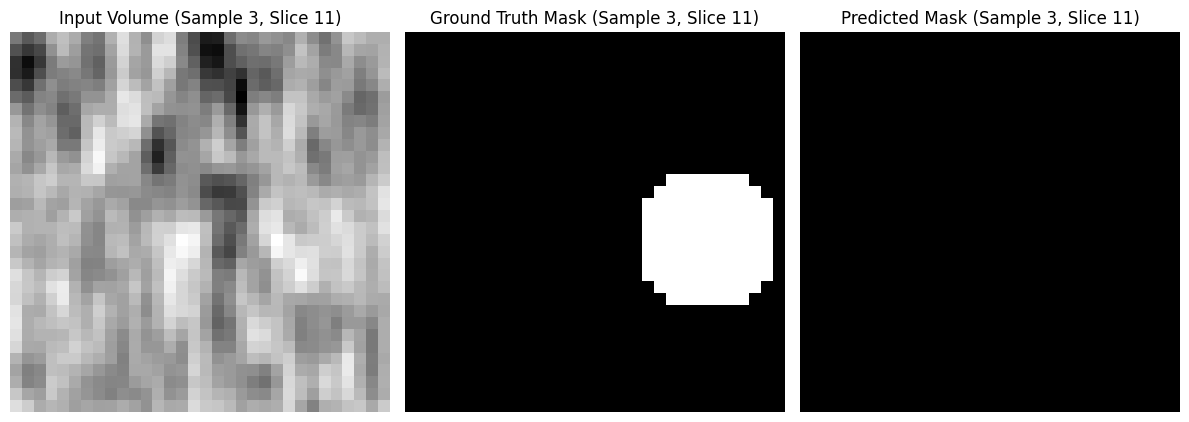

Sample 3, Slice 13 contains particles.


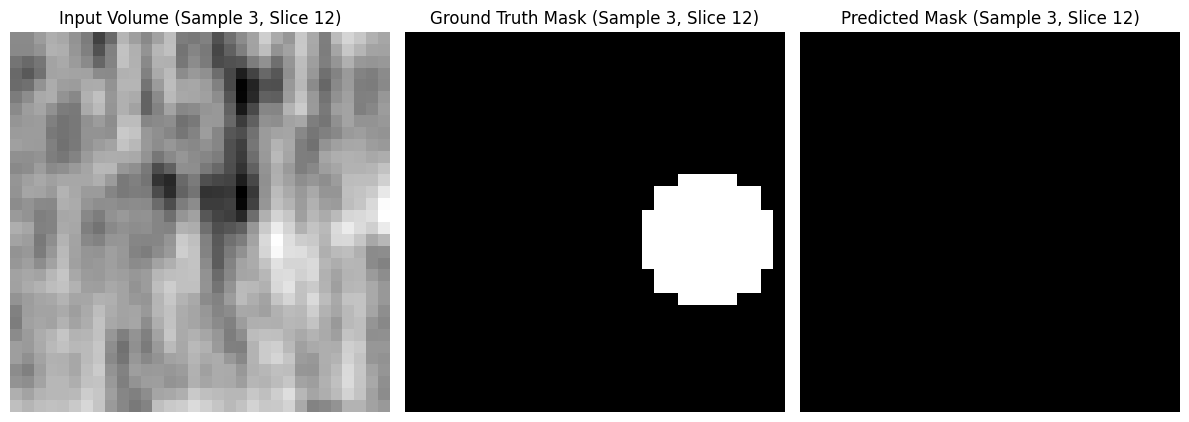

Sample 3, Slice 14 contains particles.


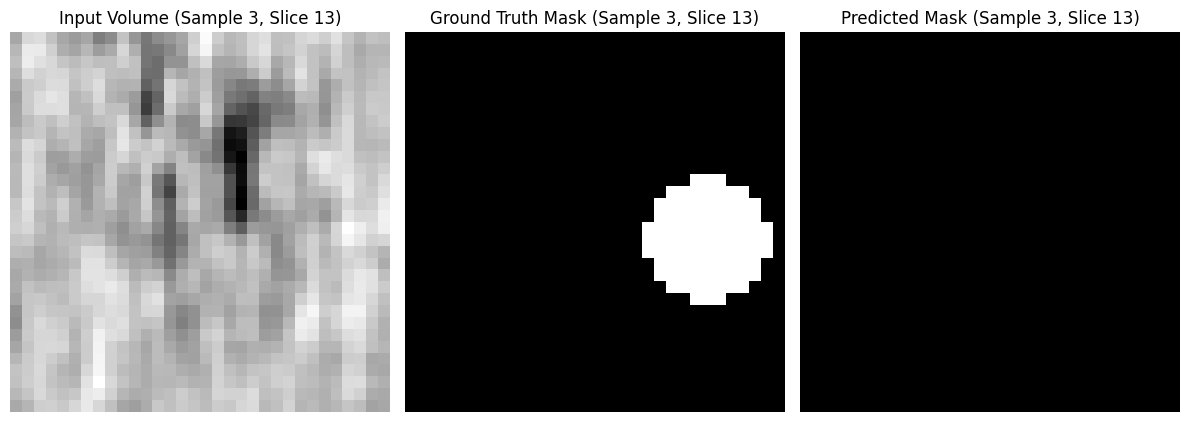

Sample 3, Slice 15 contains particles.


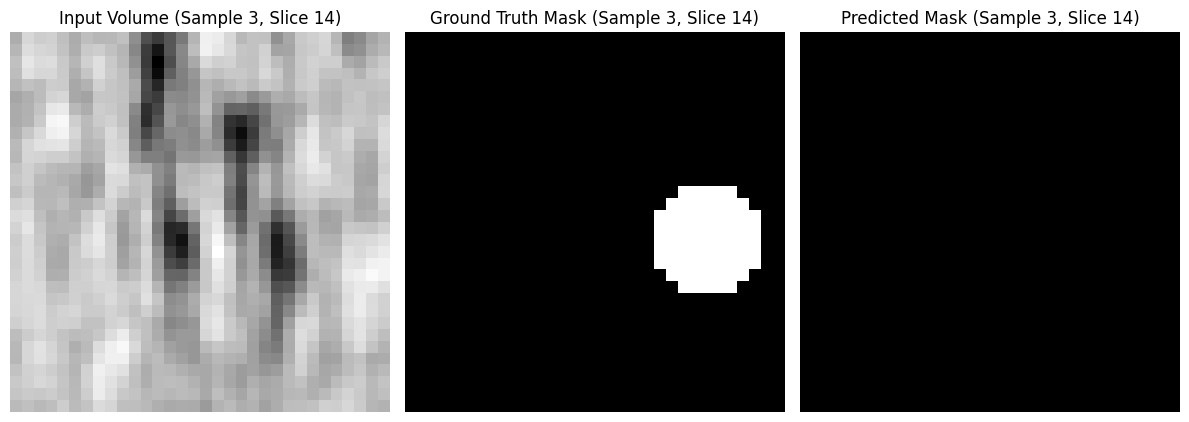

Sample 3, Slice 16 contains particles.


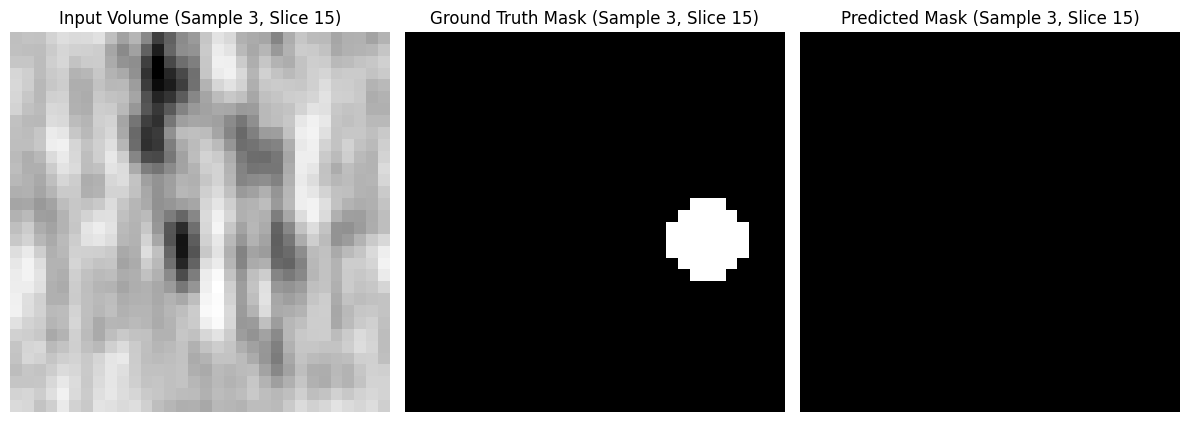

Sample 3, Slice 17 contains particles.


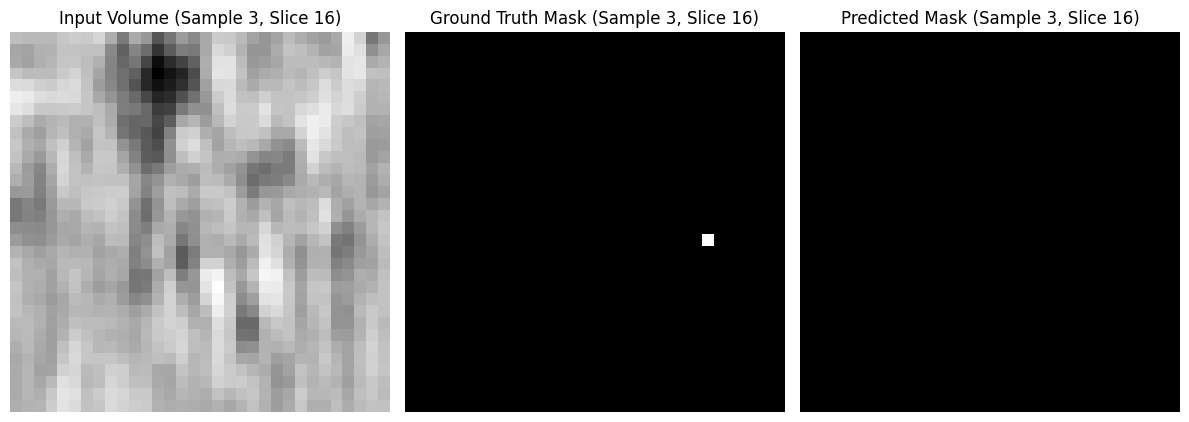

In [141]:
import torch
import matplotlib.pyplot as plt
labels = all_labels2[2]
preds = all_preds2[2]
# Iterate through the batch
for idx in range(labels.shape[0]):  # Iterate through all samples in the batch
    for slice_idx in range(labels.shape[3]):  # Iterate through depth (slices)
        # Extract ground truth and predicted mask for the slice
        ground_truth = labels[idx, :, :, slice_idx].cpu()
        predicted_mask = preds[idx, :, :, slice_idx].cpu()

        # Check if there are any particles in this slice (not limited to center)
        if (ground_truth == 1).sum() > 0:
            print(f"Sample {idx}, Slice {slice_idx + 1} contains particles.")  # Show slice index

            # Visualize the slice
            plt.figure(figsize=(12, 6))

            # Input Volume
            plt.subplot(1, 3, 1)
            plt.title(f"Input Volume (Sample {idx}, Slice {slice_idx})")
            plt.imshow(volume[idx, 0, :, :, slice_idx].cpu(), cmap="gray")
            plt.axis("off")

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.title(f"Ground Truth Mask (Sample {idx}, Slice {slice_idx})")
            plt.imshow(ground_truth, cmap="gray")
            plt.axis("off")

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.title(f"Predicted Mask (Sample {idx}, Slice {slice_idx})")
            plt.imshow(predicted_mask, cmap="gray")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

# Create the dataset for training

In [128]:
import numpy as np
import torch
from torch.utils.data import Dataset
import zarr
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass


class ParticleSubvolumeDataset(Dataset):
    def __init__(self, runs, voxel_spacing=10, volume_shape=(100, 100, 100), target_shape=(32, 32, 32),
                 radius=5, normalize=True, plot_samples=True, background_fraction=0.2):
        """
        Args:
            runs: List of run names to load the data.
            voxel_spacing: Spacing between voxels for mapping coordinates.
            volume_shape: Shape of the 3D volume.
            target_shape: Shape of the sub-volumes.
            radii: Dictionary of particle radii for label expansion.
            normalize: Whether to normalize the input volumes.
            background_fraction: Fraction of empty sub-volumes to include.
        """
        self.runs = runs
        self.voxel_spacing = voxel_spacing
        self.volume_shape = volume_shape
        self.target_shape = target_shape
        self.radius = radius
        self.normalize = normalize
        self.background_fraction = background_fraction

        # Preprocess all runs and store sub-volumes
        self.volumes, self.labels = self.preprocess_all_runs()

    def __len__(self):
        return len(self.volumes)

    def __getitem__(self, idx):
      volume = self.volumes[idx]
      label = self.labels[idx]

      # Normalize the volume to the range [0, 1]
      volume = (volume - volume.min()) / (volume.max() - volume.min())

      # Convert to tensors
      volume = torch.tensor(volume, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
      label = torch.tensor(label, dtype=torch.long)

      return volume, label

    def preprocess_all_runs(self):
        all_volumes = []
        all_labels = []
        for run in self.runs:
            zarr_data = self.read_zarr(run)
            df = self.read_run(run)
            voxel_labels = self.map_overlay_to_voxels(df, self.voxel_spacing, zarr_data.shape)

            # Debug: Check voxel labels
            # Check if there are any particles in the voxel labels
            if np.any(voxel_labels > 0):  # Only process and visualize if particles exist
                #print(f"Run: {run} contains particles")
                #print(f"Unique labels in voxel_labels: {np.unique(voxel_labels)}")
                #print(f"Shape of voxel_labels: {voxel_labels.shape}")

                # Visualize a slice of the voxel_labels
                # Visualize voxel labels with a categorical colormap
                for z in range(voxel_labels.shape[2]):
                  if np.any(voxel_labels[:, :, z] > 0):  # Check for non-zero labels
                      print(f"Slice {z} contains particles. Plotting histogram...")

                      # Extract the slice with particles
                      slice_data = voxel_labels[:, :, z]

                      # Plot the histogram of voxel values
                      #plt.figure(figsize=(8, 6))
                      #plt.hist(slice_data.ravel(), bins=range(0, 7), align='left', color='skyblue', edgecolor='black')
                      #plt.xticks(range(6))  # Assuming labels 0 to 5
                      #plt.xlabel("Voxel Label")
                      #plt.ylabel("Frequency")
                      #plt.title(f"Histogram of Voxel Labels (Slice {z})")
                      #plt.grid(axis='y', linestyle='--', alpha=0.7)
                      #plt.show()

                      # Visualize the slice
                      #plt.figure(figsize=(6, 6))
                      #plt.imshow(slice_data, cmap="tab10", vmin=0, vmax=5)
                      #plt.colorbar(label="Particle Labels")
                      #plt.title(f"Voxel Labels (Slice {z}) with Particles")
                      #plt.show()

                      break  # Stop after finding the first relevant slice
            else:
                print(f"Run: {run} contains no particles (all zeros). Skipping visualization.")
                # Initialize empty blob for all expanded labels
            voxel_labels_blob = np.zeros_like(voxel_labels, dtype=np.uint8)

            # Apply the radius to expand ribosome labels
            specific_labels = (voxel_labels == 1)  # Ribosome label is 1
            expanded_labels = self.expand_labels_with_blobs(specific_labels, radius=self.radius)
            voxel_labels_blob = np.maximum(voxel_labels_blob, expanded_labels)
            # Generate sub-volumes
            filtered_volumes, filtered_labels = self.preprocess_and_filter_subvolumes(
                zarr_data, voxel_labels_blob, self.target_shape, self.background_fraction, self.normalize
            )
            all_volumes.extend(filtered_volumes)
            all_labels.extend(filtered_labels)
            print("Starting preprocessing...")
            #print(f"Runs: {self.runs}")
            #print(f"Processed {len(self.volumes)} volumes and {len(self.labels)} labels")

        return np.array(all_volumes), np.array(all_labels)

    @staticmethod
    def read_zarr(run, resolution="0"):
      """
      Reads a Zarr dataset at a specific resolution.

      Args:
          run (str): The name of the experiment run.
          resolution (str): The resolution key to access ("0", "1", or "2").

      Returns:
          np.ndarray: The Zarr dataset as a NumPy array.
      """
      data = zarr.open(
          f"./data/train/static/ExperimentRuns/{run}/VoxelSpacing10.000/denoised.zarr",
          mode="r",
      )
      if resolution not in data:
          raise KeyError(f"Resolution '{resolution}' not found in Zarr dataset.")
      return data[resolution][:]

    @staticmethod
    def read_run(run):
        """Reads the particle data and creates a DataFrame."""
        paths = glob(f"./data/train/overlay/ExperimentRuns/{run}/Picks/*.json")
        df = pd.concat([pd.read_json(x) for x in paths]).reset_index(drop=True)
        for axis in "x", "y", "z":
            df[axis] = df.points.apply(lambda x: x["location"][axis])
        for key in "transformation_", "instance_id":
            df[key] = df.points.apply(lambda x: x[key])
        return df

    @staticmethod
    def map_overlay_to_voxels(df, voxel_spacing, volume_shape):
        """Maps particle coordinates to voxel labels for the ribosome."""
        voxel_labels = np.zeros(volume_shape, dtype=int)
        for _, row in df.iterrows():
            if row["pickable_object_name"] == "virus-like-particle":  # Filter for ribosome only
                x, y, z = [int(row[axis] / voxel_spacing) for axis in ["x", "y", "z"]]
                voxel_labels[z, y, x] = 1  # Assign ribosome label as 1
        return voxel_labels

    @staticmethod
    def expand_labels_with_blobs(voxel_labels, radius):
        """Expands centroids into blobs."""
        radius = int(radius)
        z, y, x = np.ogrid[-radius:radius+1, -radius:radius+1, -radius:radius+1]
        distance = np.sqrt(x**2 + y**2 + z**2)
        sphere = distance <= radius
        expanded_labels = np.zeros_like(voxel_labels, dtype=np.uint8)
        centroids = np.argwhere(voxel_labels > 0)
        for cz, cy, cx in centroids:
            z_min, z_max = max(0, cz - radius), min(voxel_labels.shape[0], cz + radius + 1)
            y_min, y_max = max(0, cy - radius), min(voxel_labels.shape[1], cy + radius + 1)
            x_min, x_max = max(0, cx - radius), min(voxel_labels.shape[2], cx + radius + 1)
            roi = expanded_labels[z_min:z_max, y_min:y_max, x_min:x_max]
            sphere_roi = sphere[
                max(0, radius - cz):min(2 * radius + 1, radius + voxel_labels.shape[0] - cz),
                max(0, radius - cy):min(2 * radius + 1, radius + voxel_labels.shape[1] - cy),
                max(0, radius - cx):min(2 * radius + 1, radius + voxel_labels.shape[2] - cx),
            ]
            #roi[sphere_roi] = voxel_labels[cz, cy, cx]
            roi[sphere_roi] = 1
        return expanded_labels

    @staticmethod
    def preprocess_and_filter_subvolumes(zarr_data, labels, target_shape, background_fraction, normalize, plot_samples=True):
        """Filters sub-volumes based on the presence of relevant data."""
        sub_volumes = []
        sub_labels = []
        background_volumes = []
        background_labels = []
        for x in range(0, zarr_data.shape[0] - target_shape[0] + 1, target_shape[0]):
            for y in range(0, zarr_data.shape[1] - target_shape[1] + 1, target_shape[1]):
                for z in range(0, zarr_data.shape[2] - target_shape[2] + 1, target_shape[2]):
                    crop = zarr_data[x:x + target_shape[0], y:y + target_shape[1], z:z + target_shape[2]]
                    crop_label = labels[x:x + target_shape[0], y:y + target_shape[1], z:z + target_shape[2]]
                    if np.any(crop_label > 0):
                        sub_volumes.append(crop)
                        sub_labels.append(crop_label)
                    else:
                        background_volumes.append(crop)
                        background_labels.append(crop_label)
        if background_fraction > 0 and len(background_volumes) > 0:
            sample_size = int(len(sub_volumes) * background_fraction)
            sampled_indices = np.random.choice(len(background_volumes), size=sample_size, replace=False)
            sub_volumes.extend([background_volumes[i] for i in sampled_indices])
            sub_labels.extend([background_labels[i] for i in sampled_indices])
        if normalize:
            sub_volumes = (np.array(sub_volumes) - np.min(sub_volumes)) / (np.max(sub_volumes) - np.min(sub_volumes))

        if plot_samples:
            plot_indices = np.random.choice(len(sub_volumes), size=min(3, len(sub_volumes)), replace=False)
            for idx in plot_indices:
              volume = sub_volumes[idx]
              label = sub_labels[idx]
              print(f"Volume shape: {volume.shape}")
              print(f"Label shape: {label.shape}")
              # Call plot_ground_truth here
              ParticleSubvolumeDataset.plot_ground_truth(volume, label)
        return sub_volumes, sub_labels

    @staticmethod
    def count_particles_and_centroids(label_volume):
      print('############### COUNT PARTICLES AND CENTROIDS##############')
      """
      Counts the number of particles and calculates their centroids.

      Parameters:
          label_volume (numpy.ndarray): 3D label volume with particle labels.

      Returns:
          particle_count (int): Number of particles in the volume.
          centroids (list of tuples): List of (z, y, x) centroids for each particle.
      """
      # Label connected components in the volume
      labeled_volume, particle_count = label(label_volume > 0)

      # Calculate centroids for each particle
      centroids = center_of_mass(label_volume, labeled_volume, range(1, particle_count + 1))

      return particle_count, centroids

    @staticmethod

    def plot_ground_truth(volume, label):
      """
      Plots the ground truth volume and label, and displays particle count and centroids.

      Parameters:
          volume (numpy.ndarray): 3D volume data.
          label (numpy.ndarray): 3D label volume with particle labels.
      """
      # Count particles and calculate centroids
      particle_count, centroids = ParticleSubvolumeDataset.count_particles_and_centroids(label)

      # Print particle information
      print(f"Number of particles in the plotted volume: {particle_count}")
      print("Centroids (z, y, x) of particles:")
      for i, centroid in enumerate(centroids, 1):
          print(f"  Particle {i}: {centroid}")

      # Select the middle slice for plotting
      middle_slice = volume.shape[0] // 2

      # Plot volume and label
      fig, axs = plt.subplots(1, 2, figsize=(12, 6))
      axs[0].imshow(volume[middle_slice, :, :], cmap="gray")
      axs[0].set_title("Input Volume (Middle Slice)")
      axs[0].axis("off")

      axs[1].imshow(label[middle_slice, :, :], cmap="viridis")
      axs[1].set_title("Ground Truth Label (Middle Slice)")
      axs[1].axis("off")

      plt.tight_layout()
      plt.show()

    @staticmethod
    def plot_all_slices_with_particles(volume, label):
      """
      Plots all slices of the volume and highlights slices containing particles.

      Parameters:
          volume (numpy.ndarray): 3D volume data.
          label (numpy.ndarray): 3D label volume with particle labels.
      """
      print('**************PLOT ALL SLICES WITH PARTICLES******************')
      particle_slices = np.any(label > 0, axis=(1, 2))  # Check which z-slices contain particles

      for z in range(label.shape[0]):
          if particle_slices[z]:  # Only plot slices with particles
              fig, axs = plt.subplots(1, 2, figsize=(12, 6))
              axs[0].imshow(volume[z, :, :], cmap="gray")
              axs[0].set_title(f"Input Volume (Slice {z})")
              axs[0].axis("off")

              axs[1].imshow(label[z, :, :], cmap="viridis")
              axs[1].set_title(f"Ground Truth Label (Slice {z})")
              axs[1].axis("off")

              plt.tight_layout()
              plt.show()
    @staticmethod
    def plot_with_centroids(volume, label, centroids):
      """
      Plots the volume and label slice with centroid markers for particles.

      Parameters:
          volume (numpy.ndarray): 3D volume data.
          label (numpy.ndarray): 3D label volume with particle labels.
          centroids (list of tuples): List of centroids (z, y, x) for particles.
      """
      print('**************PLOT WITH CENTROIDS******************')
      middle_slice = volume.shape[0] // 2

      fig, axs = plt.subplots(1, 2, figsize=(12, 6))

      axs[0].imshow(volume[middle_slice, :, :], cmap="gray")
      axs[0].set_title("Input Volume (Middle Slice)")
      axs[0].axis("off")

      axs[1].imshow(label[middle_slice, :, :], cmap="viridis")
      axs[1].set_title("Ground Truth Label (Middle Slice)")
      axs[1].axis("off")

      # Highlight centroids if they fall in the middle slice
      for centroid in centroids:
          z, y, x = centroid
          if int(z) == middle_slice:  # Check if centroid is in the middle slice
              axs[1].scatter(x, y, color="red", marker="o", s=50, label="Centroid")

      plt.tight_layout()
      plt.show()

    def debug_plot(self, idx):
        """
        Debugging method to visualize a specific volume and its label by index.

        Parameters:
            idx (int): Index of the volume and label to visualize.
        """
        volume = self.volumes[idx]
        label = self.labels[idx]

        # Count particles and centroids
        particle_count, centroids = self.count_particles_and_centroids(label)

        # Print particle information
        print(f"Index: {idx}")
        print(f"Number of particles: {particle_count}")
        print("Centroids (z, y, x):")
        for i, centroid in enumerate(centroids, 1):
            print(f"  Particle {i}: {centroid}")

        # Plot slices with particles
        self.plot_all_slices_with_particles(volume, label)

        # Plot the middle slice with centroid markers
        self.plot_with_centroids(volume, label, centroids)

    '''
    def plot_ground_truth(volume, label):

      fig, axs = plt.subplots(1, 2, figsize=(12, 6))

      # Plot a single slice from the middle of the volume
      print("*************Ploting**************")
      middle_slice = volume.shape[0] // 2
      axs[0].imshow(volume[middle_slice, :, :], cmap="gray")
      axs[0].set_title("Input Volume (Middle Slice)")
      axs[0].axis("off")

      axs[1].imshow(label[middle_slice, :, :], cmap="viridis")
      axs[1].set_title("Ground Truth Label (Middle Slice)")
      axs[1].axis("off")

      plt.tight_layout()
      plt.show()
    '''

Slice 11 contains particles. Plotting histogram...
Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (28.0, 0.02631578947368421, 11.0)


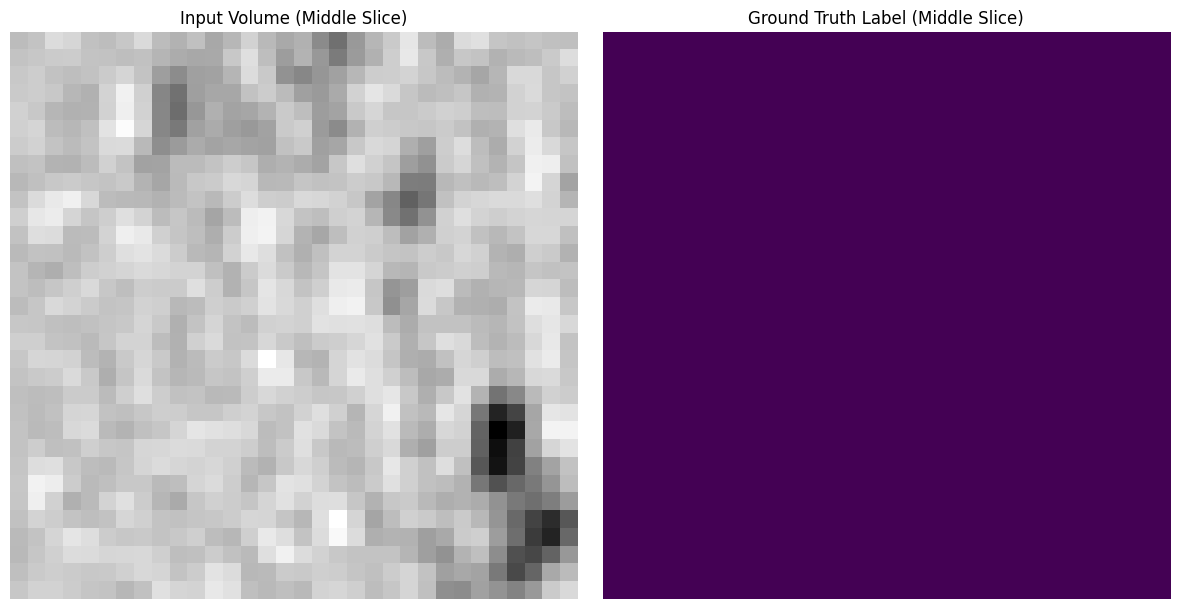

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (27.401282051282053, 26.755128205128205, 11.0)


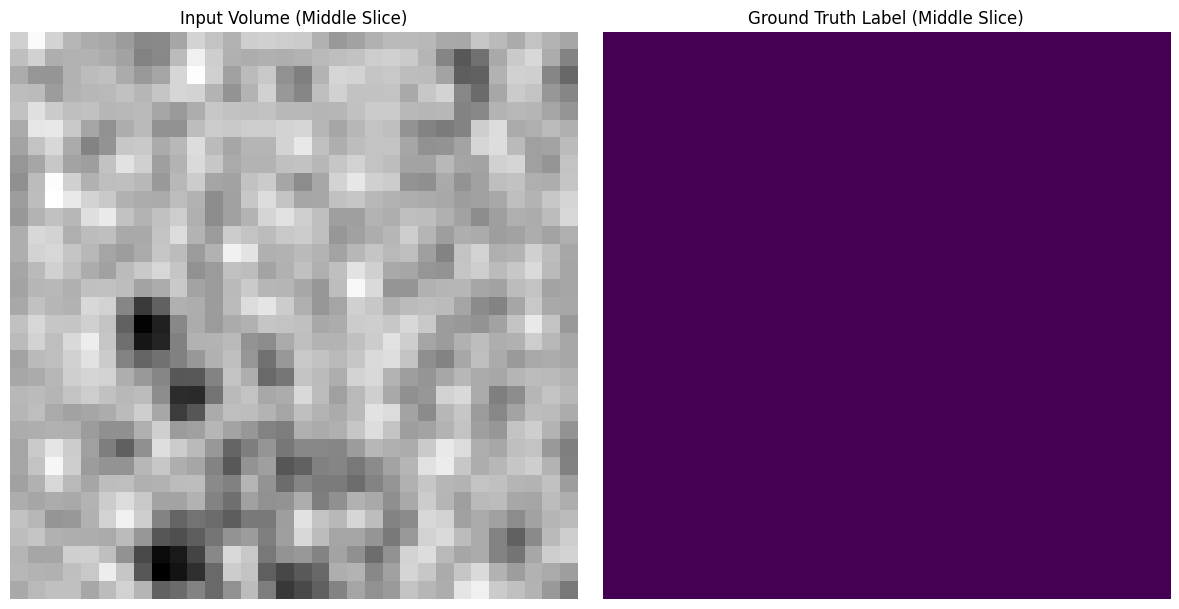

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (29.426108374384235, 5.0, 7.0)


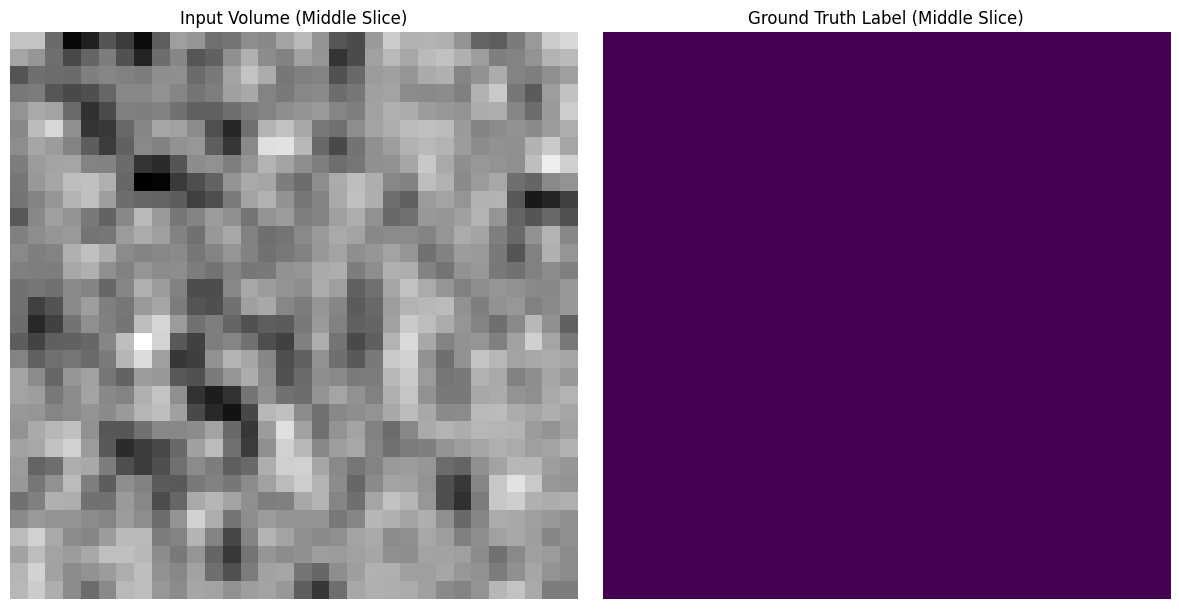

Starting preprocessing...
Slice 23 contains particles. Plotting histogram...
Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (1.1515151515151516, 7.0, 16.0)


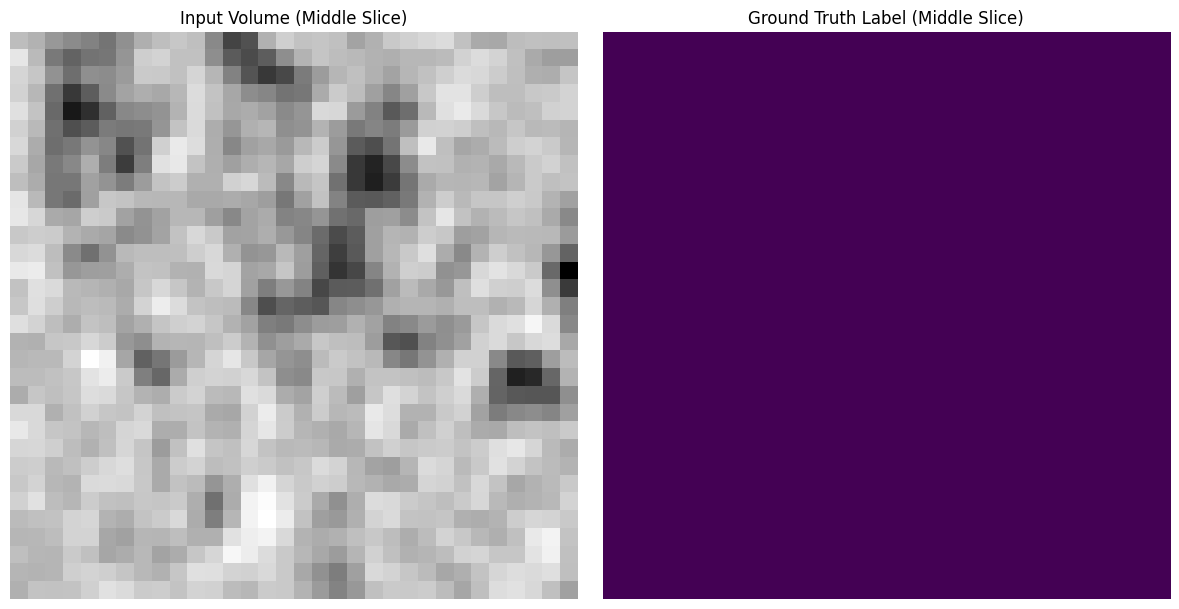

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (17.0, 8.0, 30.255102040816325)


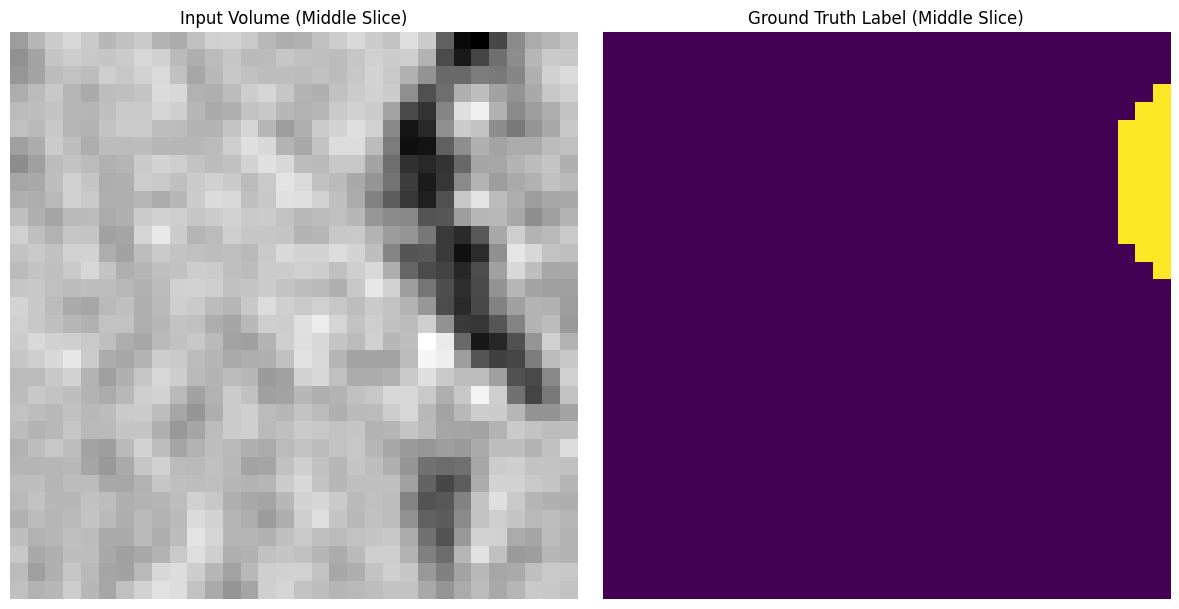

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (15.0, 8.0, 23.0)


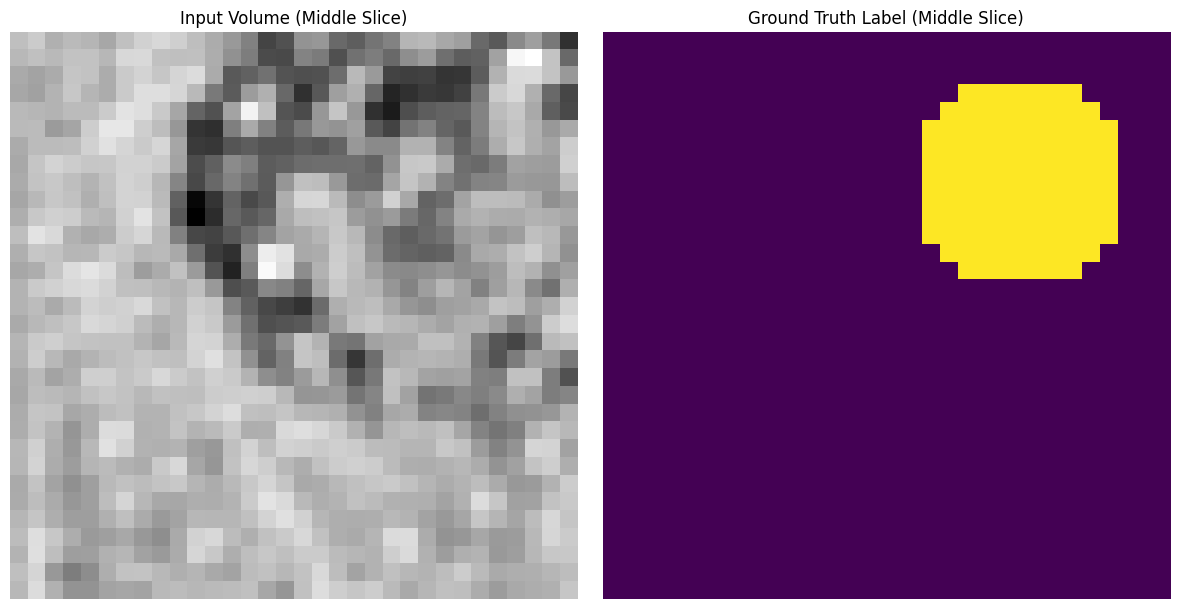

Starting preprocessing...
Slice 12 contains particles. Plotting histogram...
Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (10.0, 18.0, 12.0)


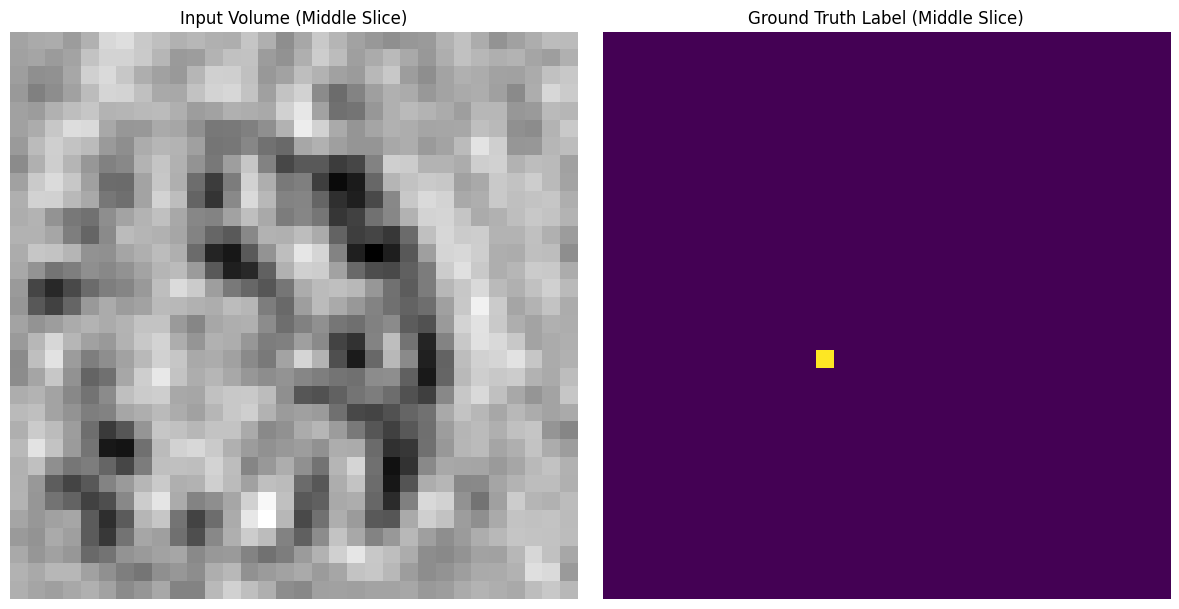

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (10.0, 10.0, 27.429095354523227)


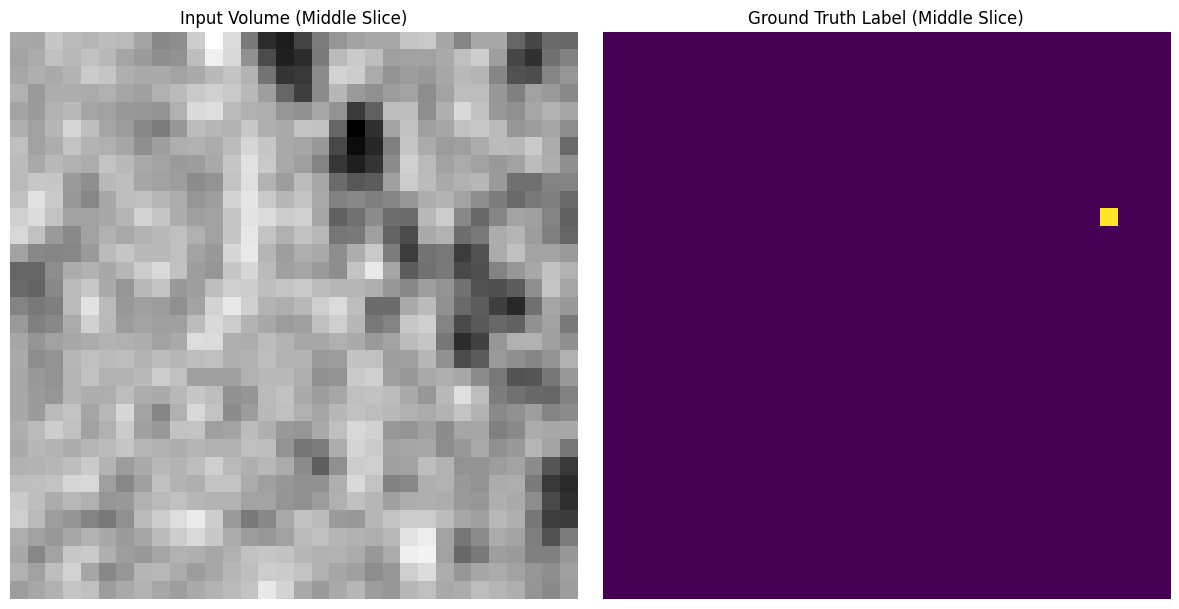

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (15.0, 28.986512524084777, 17.0)


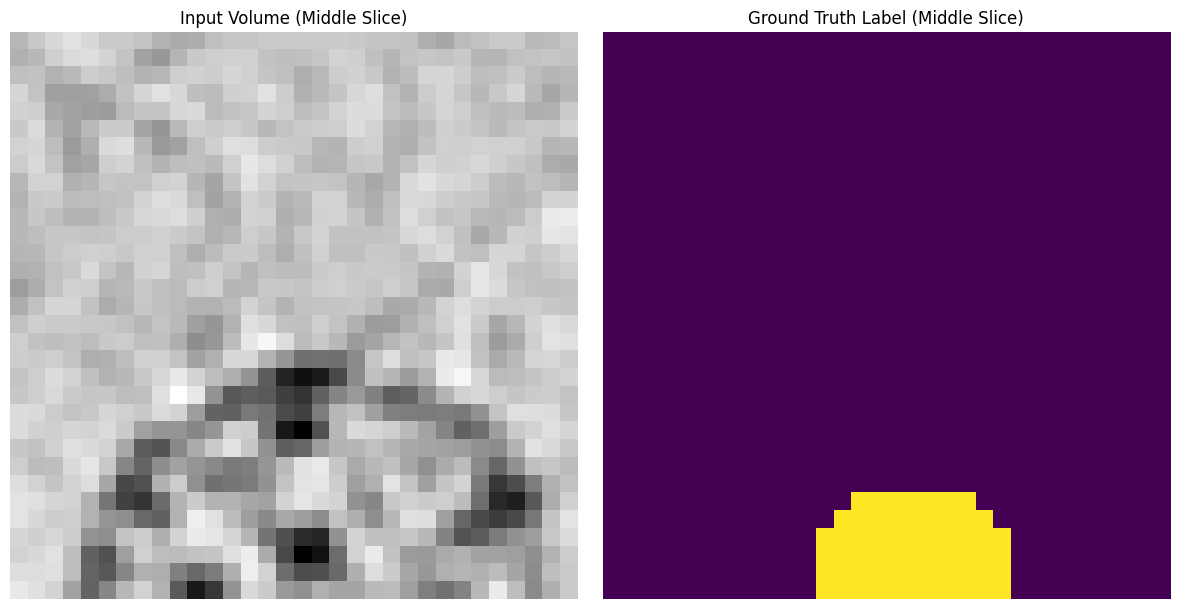

Starting preprocessing...
Slice 23 contains particles. Plotting histogram...
Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (23.0, 30.608695652173914, 2.5434782608695654)


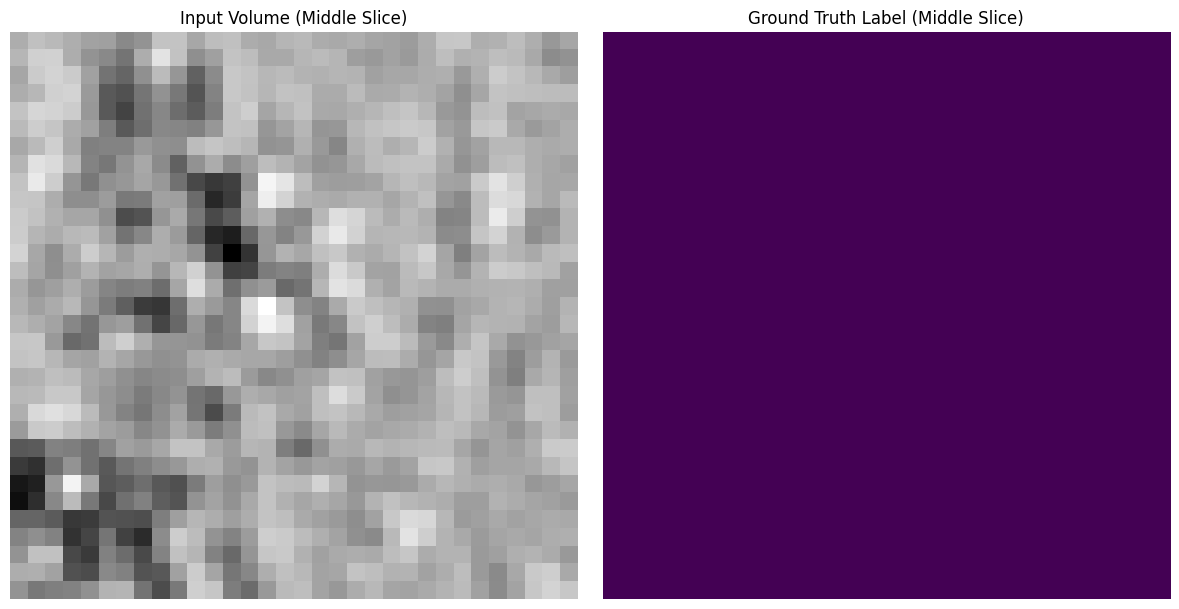

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (1.1515151515151516, 11.0, 17.0)


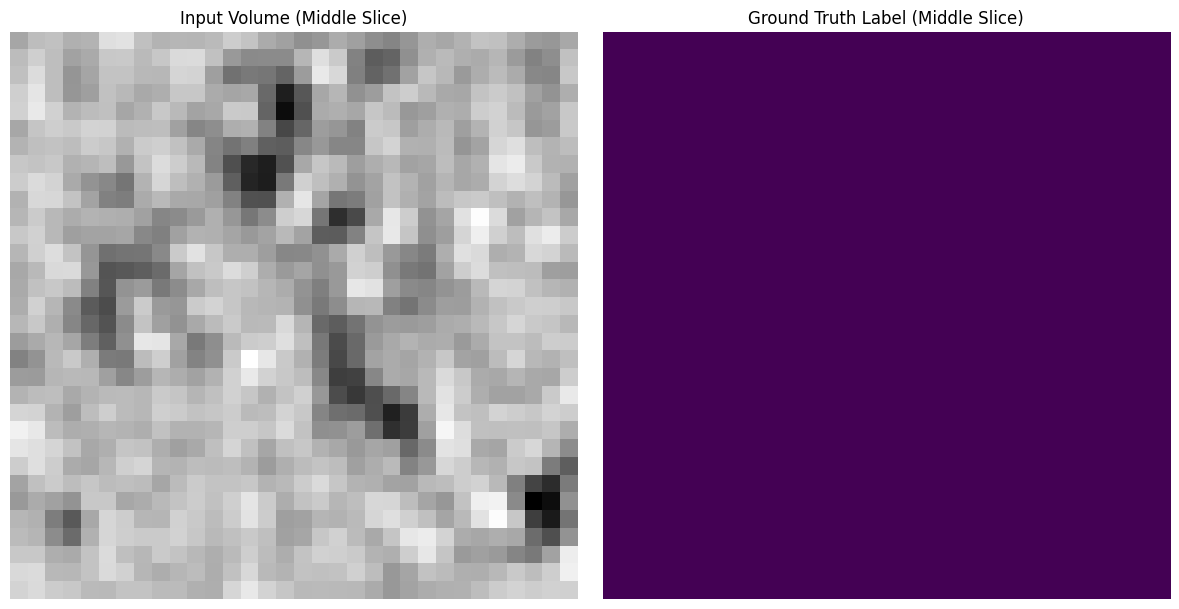

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (4.215332581736189, 6.0, 24.0)


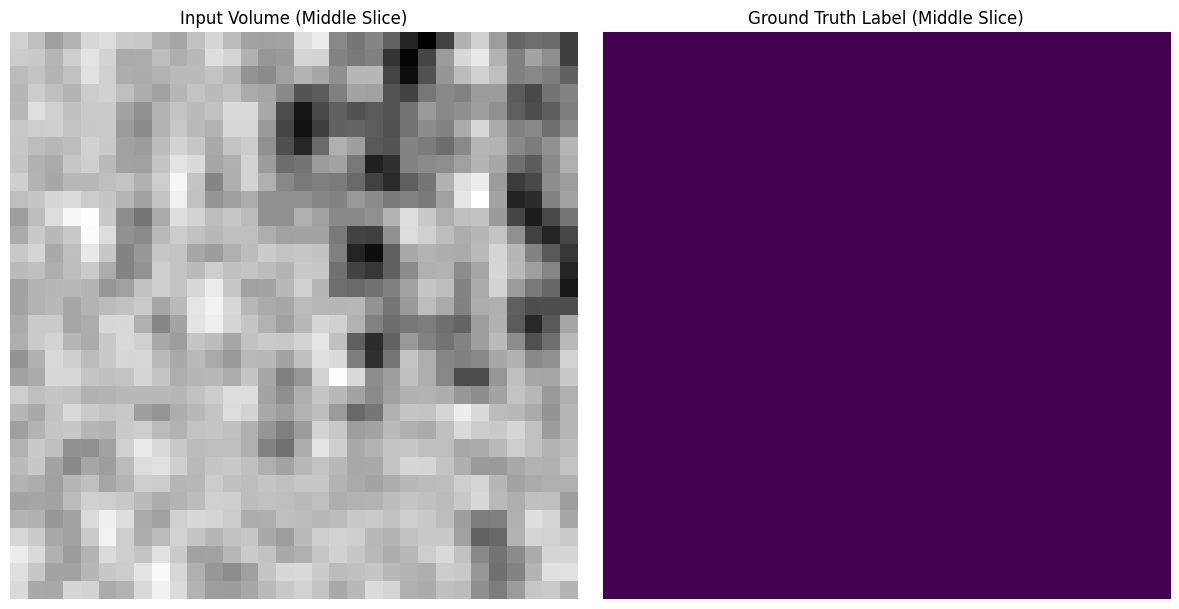

Starting preprocessing...
Slice 67 contains particles. Plotting histogram...
Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (6.0, 9.0, 4.215332581736189)


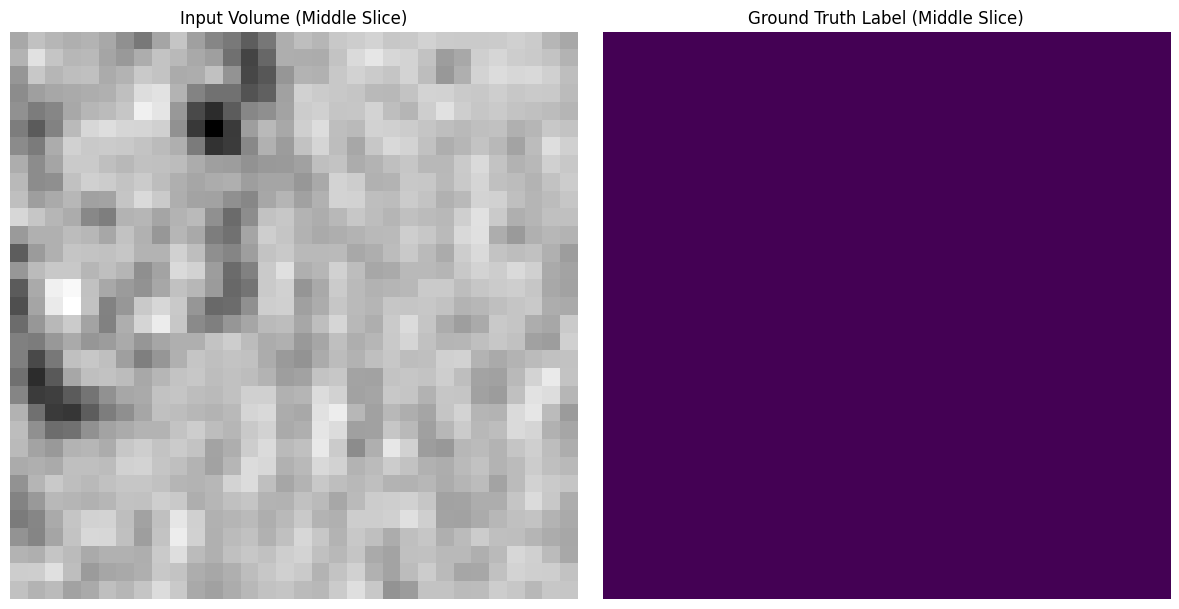

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (0.0, 21.0, 31.0)


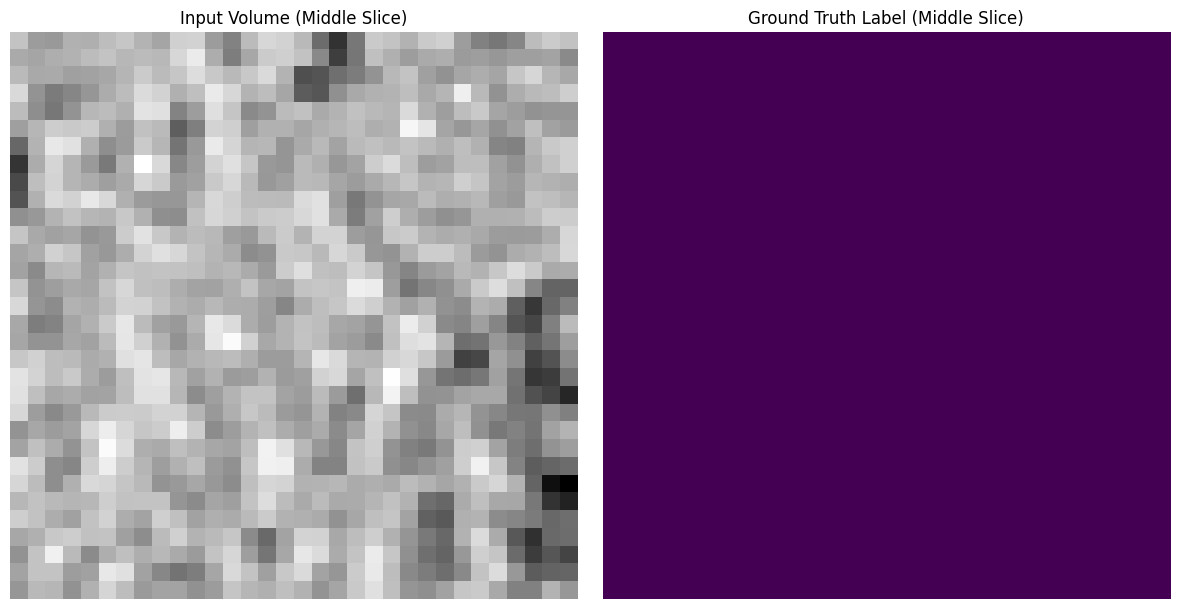

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (6.0, 6.0, 21.0)


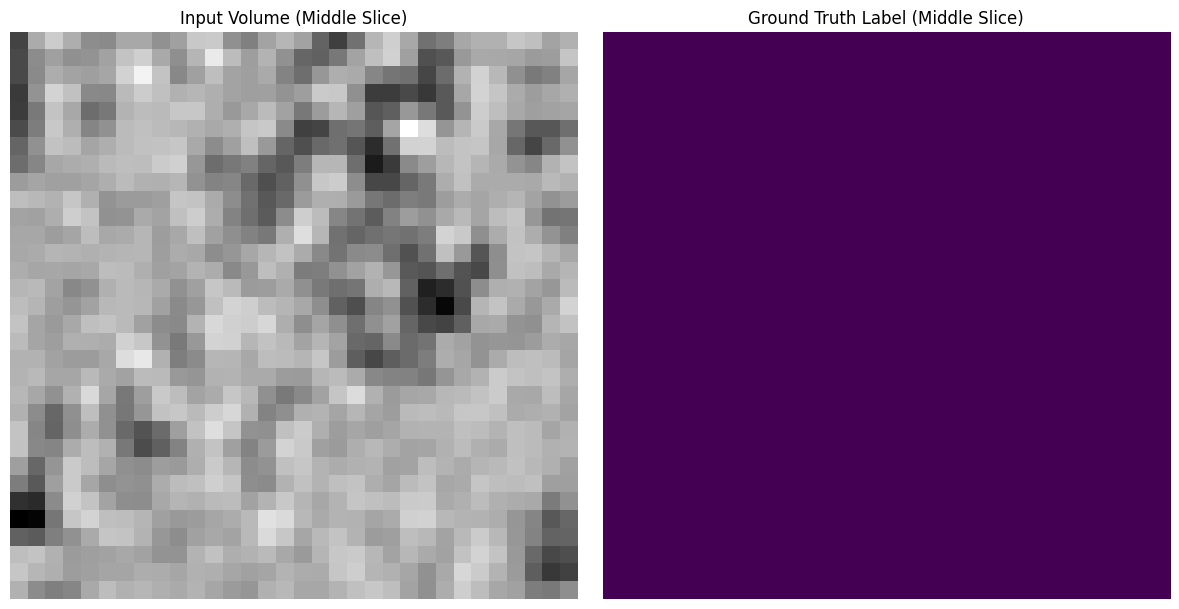

Starting preprocessing...
Slice 15 contains particles. Plotting histogram...
Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (29.869565217391305, 0.043478260869565216, 15.0)


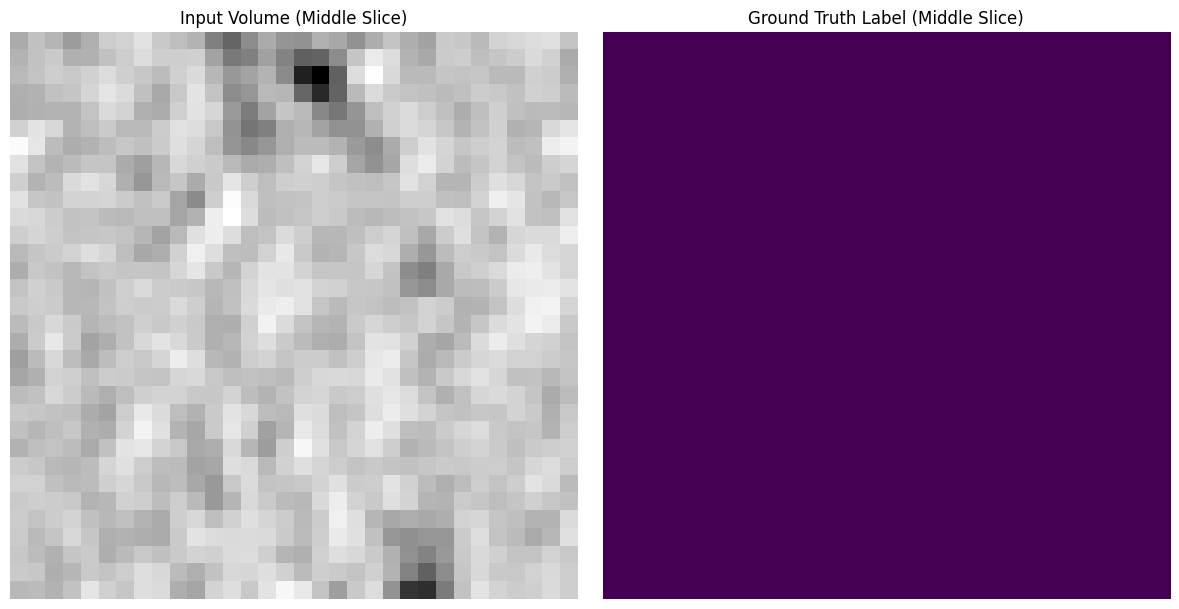

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (29.821428571428573, 29.13095238095238, 8.0)


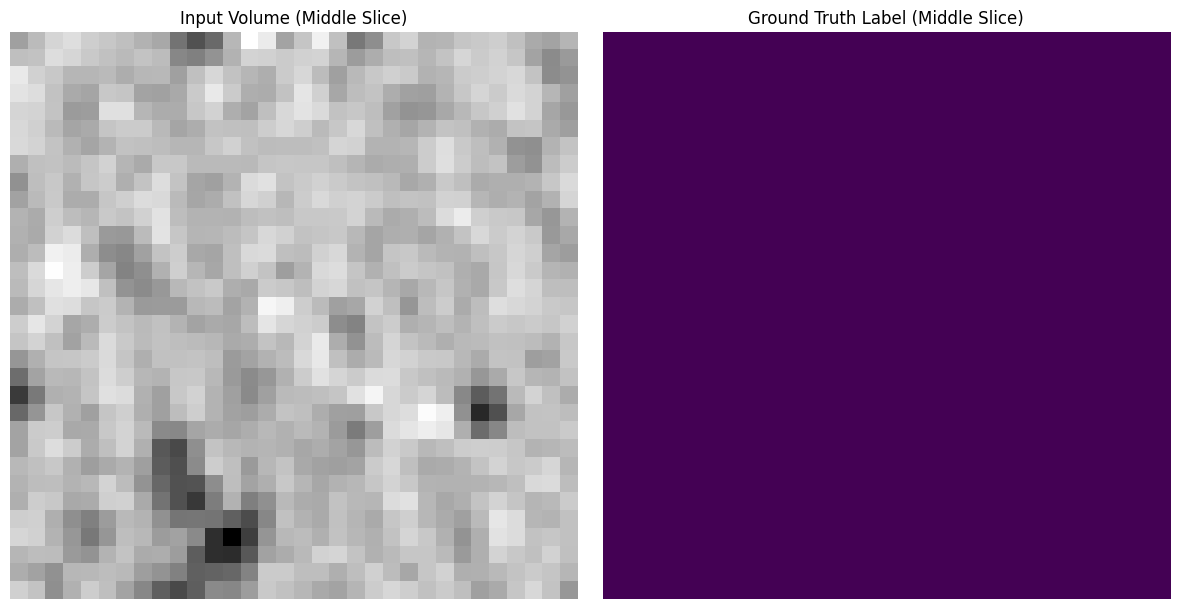

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (11.0, 11.0, 2.4904458598726116)


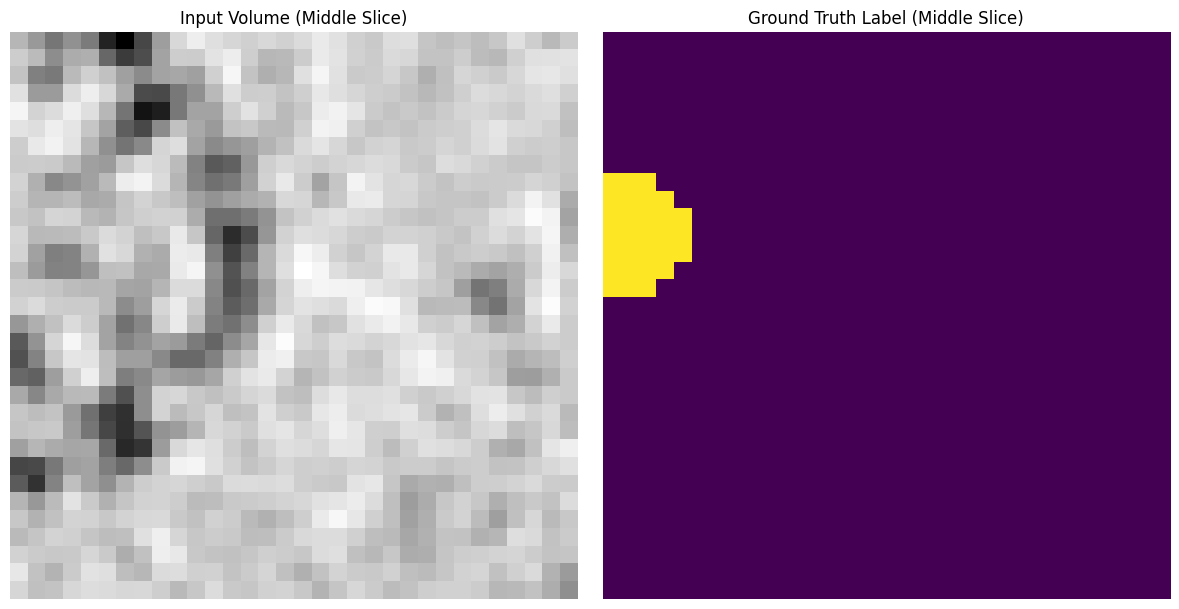

Starting preprocessing...
Slice 28 contains particles. Plotting histogram...
Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 0
Centroids (z, y, x) of particles:


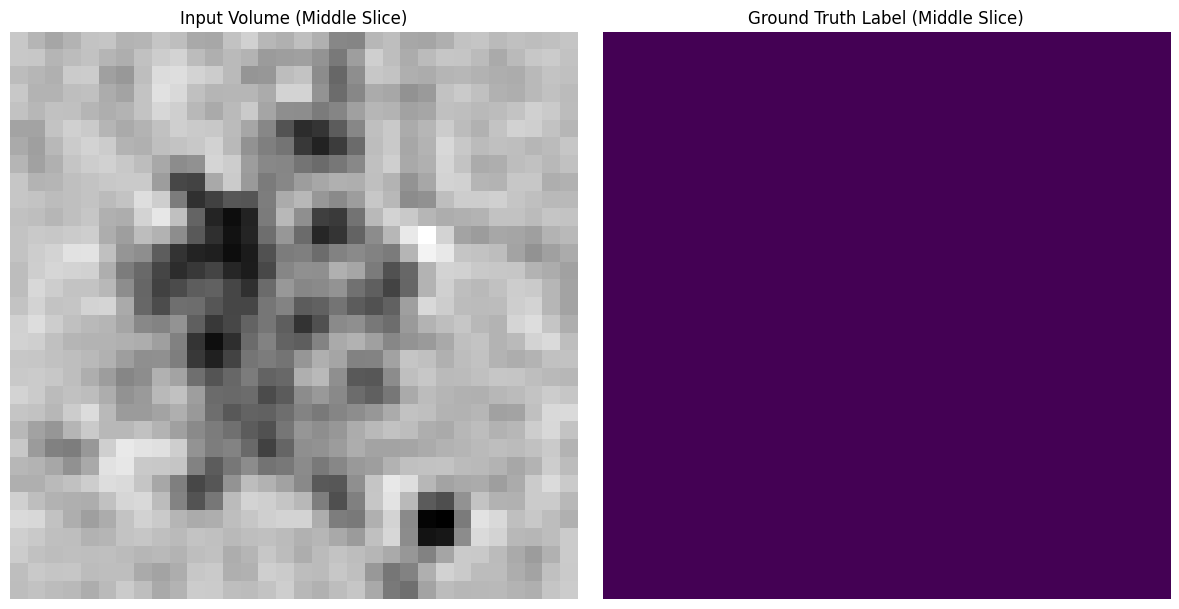

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (1.1515151515151516, 5.0, 17.0)


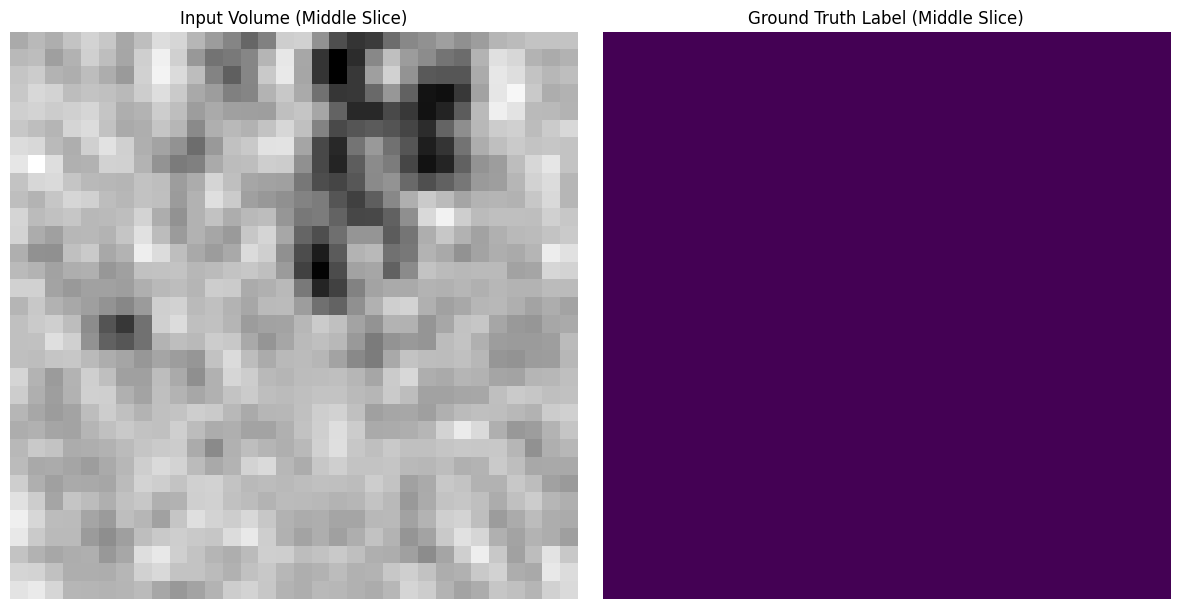

Volume shape: (32, 32, 32)
Label shape: (32, 32, 32)
############### COUNT PARTICLES AND CENTROIDS##############
Number of particles in the plotted volume: 1
Centroids (z, y, x) of particles:
  Particle 1: (1.5337078651685394, 15.0, 29.46629213483146)


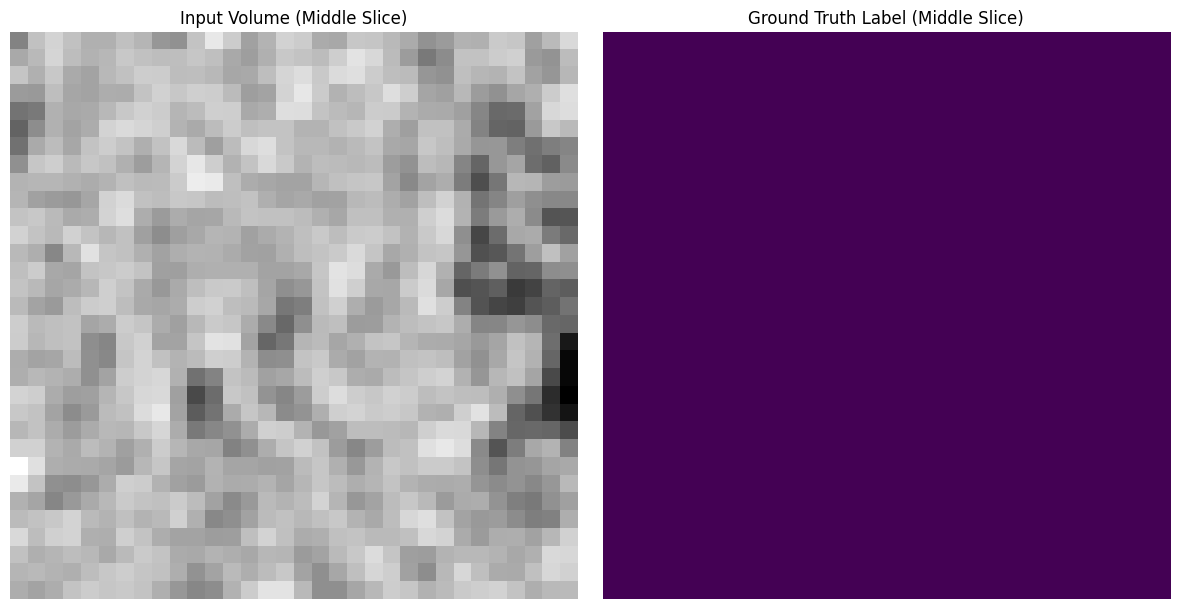

Starting preprocessing...
############### COUNT PARTICLES AND CENTROIDS##############
Index: 0
Number of particles: 1
Centroids (z, y, x):
  Particle 1: (31.0, 5.0, 25.0)
**************PLOT ALL SLICES WITH PARTICLES******************


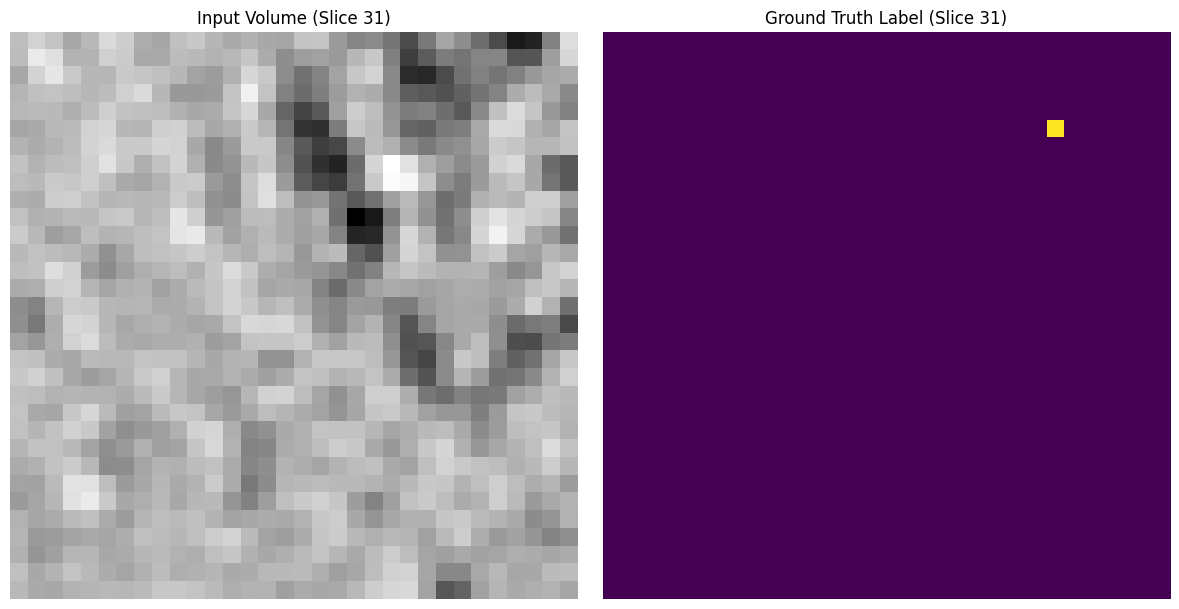

**************PLOT WITH CENTROIDS******************


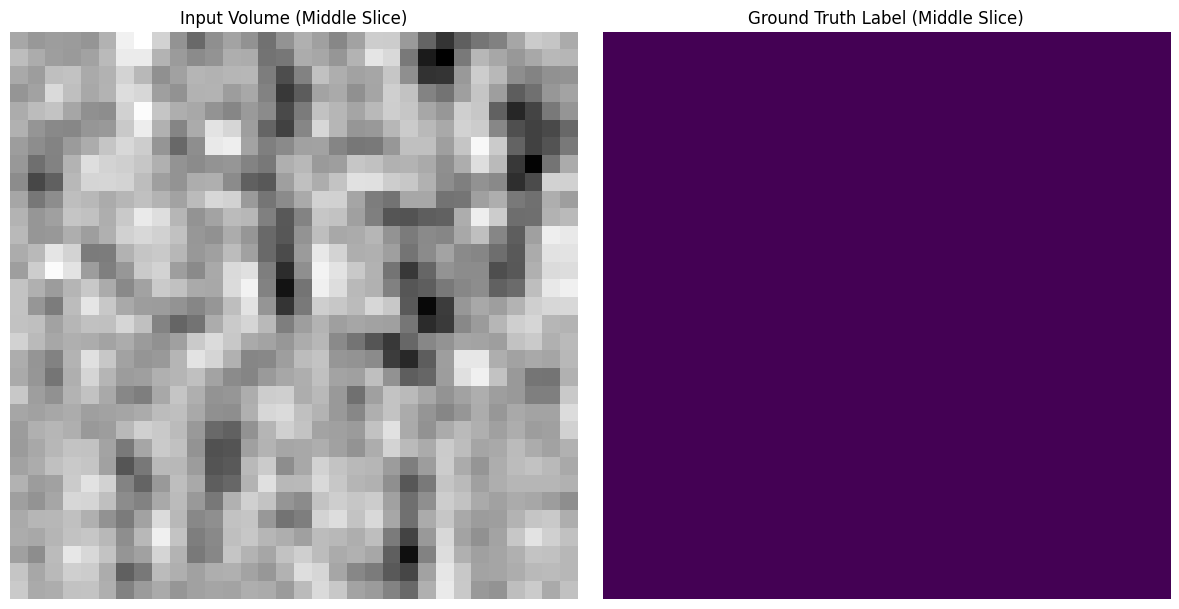

Number of training samples: 253
Number of validation samples: 64


In [134]:
from torch.utils.data import DataLoader, random_split
import os
from glob import glob

# List of experiment runs
runs = sorted(glob('./data/train/overlay/ExperimentRuns/*'))
runs = [os.path.basename(x) for x in runs]


ribosome_radius = 6.75  # Set the radius specific to the ribosome particle


dataset = ParticleSubvolumeDataset(
    runs=runs,
    voxel_spacing=10,
    target_shape=(32, 32, 32),
    radius=ribosome_radius,  # Use the ribosome-specific radius
    background_fraction=0.2
)

# Debugging: Visualize the first sample
dataset.debug_plot(0)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Check DataLoader sizes
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

In [ ]:
print(volume.device, labels.device)

cuda:0 cuda:0


In [ ]:
total_voxels = sum(class_counts.values())
background_percentage = (class_counts.get(0, 0) / total_voxels) * 100
foreground_percentage = (class_counts.get(1, 0) / total_voxels) * 100

print(f"Background (0): {background_percentage:.2f}%")
print(f"Foreground (1): {foreground_percentage:.2f}%")


Background (0): 99.69%
Foreground (1): 0.31%


In [ ]:
print(f"Volume Min: {volume.min()}, Max: {volume.max()}")


Volume Min: 0.0, Max: 1.0


In [ ]:
print(f"Labels Min: {labels.min()}, Max: {labels.max()}, Shape: {labels.shape}")


Labels Min: 0, Max: 1, Shape: torch.Size([4, 32, 32, 32])
